# Factors Influencing Student Exam Performance: Multi-Model Analysis  

## Felicia D. O'Garro

### Executive Summary

Understanding the factors that influence student performance is critical for designing effective interventions to improve academic outcomes. Factors such as study habits, parental involvement, attendance, prior achievement, access to tutoring, and parental education levels all contribute to academic success, but their relative importance and interactions remain unclear. This study aims to address this gap by investigating the drivers of exam scores using a dataset of 6,607 records and 20 features, including exam scores, attendance, study habits, and parental involvement.

This research employs a comprehensive methodology to uncover patterns and relationships in the data. Correlation analysis, heatmaps and other visualizations will identify initial relationships among variables. Regression models will quantify the combined effects of predictors, such as hours studied, attendance, and parental involvement, on exam scores. Bayesian models will integrate prior knowledge, such as the relationship between exam scores and previous performance, to refine predictions. Poisson models will provide insights into count data, such as tutoring sessions. Through these techniques, we aim to identify the most significant predictors and understand the interactions among them.

The findings from this research are expected to provide actionable insights. Key insights include the relationship between study time, attendance, and exam scores; the impact of parental involvement and education on student success; and the role of academic resources, such as tutoring, in improving performance. These results will guide the design of targeted interventions, enabling more equitable learning opportunities and resource allocation.

By using a multi-faceted analytical approach, this research seeks to answer critical questions about the drivers of student success, providing a robust foundation for improving academic outcomes in diverse educational settings.

### Importing Libraries and Loading Data

The initial step involves importing the necessary libraries for data analysis and visualization. Subsequently, the "Student Performance Factors" dataset, sourced from Kaggle: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors/data, will be loaded. This dataset comprises information relevant to student performance, including but not limited to study habits, attendance, and parental involvement.

In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import contextlib
import io
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from patsy import dmatrices
from sklearn import metrics
import contextlib
import io
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
from sklearn.model_selection import KFold

%matplotlib inline
sns.set(style='ticks', palette='Set2')

In [ ]:
df = pd.read_csv('StudentPerformanceFactors.csv')
df.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [ ]:
df.head()

Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Yes                  0           Low          Medium   
1             Yes                  2        Medium          Medium   
2             Yes                  2        Medium          Medium   
3             Yes                  1        Medium          Medium   
4             Yes                  3        Medium            High   

  School_Type Peer_Influence  Physical_Activity Learning_Disabilities  \
0      Public       Positive                  3                    No   
1      Public       Negative                  4                    No   
2      Public        Neutral                  4                    No   
3      Public       Negative                  4                    No   
4      Public        Neutral                  4                    No   

  Parental_Education_Level Distance_from_Home  Gender  Exam_Score  
0              High School               Near    Male          67  
1                  College           Moderate  Female          61  
2             Postgraduate               Near    Male          74  
3              High School           Moderate    Male          71  
4                  College               Near  Female          70

In [ ]:
# Count missing values per column
missing_values = df.isnull().sum()

# Display columns with missing values
print("Missing Values per Column:")
print(missing_values[missing_values > 0])

Missing Values per Column:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64


### Preparing The Data

In preparing the dataset, I addressed missing values and introduced a unique identifier for each student.  Approximately 200 missing values were observed across the 'Teacher Quality,' 'Parental Education Level,' and 'Distance From Home' columns. Given the dataset's size of nearly 7,000 records, these missing values were dropped. To ensure individual student performance could be tracked, a new column named 'Student ID' was added to the DataFrame. Additionally, several columns with categorical variables were encoded to facilitate numerical analysis. This encoding provides flexibility in representing categorical data for modeling and exploration. Finally, the describe() method was used to gain an overview of the summary statistics for each column in the DataFrame.

In [ ]:
# Drop rows with missing values
df.dropna(inplace=True)

In [ ]:
# confirm rows in dataframe
len(df)

6378

In [ ]:
#assign student ids
df['StudentID'] = range(1, len(df) + 1)

In [ ]:
df.head()

Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6               65           Medium   

  Internet_Access  Tutoring_Sessions  ... Teacher_Quality School_Type  \
0             Yes                  0  ...          Medium      Public   
1             Yes                  2  ...          Medium      Public   
2             Yes                  2  ...          Medium      Public   
3             Yes                  1  ...          Medium      Public   
4             Yes                  3  ...            High      Public   

  Peer_Influence Physical_Activity  Learning_Disabilities  \
0       Positive                 3                     No   
1       Negative                 4                     No   
2        Neutral                 4                     No   
3       Negative                 4                     No   
4        Neutral                 4                     No   

  Parental_Education_Level Distance_from_Home  Gender Exam_Score  StudentID  
0              High School               Near    Male         67          1  
1                  College           Moderate  Female         61          2  
2             Postgraduate               Near    Male         74          3  
3              High School           Moderate    Male         71          4  
4                  College               Near  Female         70          5  

[5 rows x 21 columns]

In [ ]:
# encode categorical variables
def convert_categorical(df, categorical_vars):
  for var in categorical_vars:
    # Create a mapping dictionary
    unique_values = df[var].unique()
    value_map = {value: i for i, value in enumerate(unique_values)}

    # Convert the variable using the map
    df[var] = df[var].map(value_map)

  return df


categorical_variables = [
    'Parental_Involvement',
    'Access_to_Resources',
    'Extracurricular_Activities',
    'Motivation_Level',
    'Internet_Access',
    'Family_Income',
    'Teacher_Quality',
    'School_Type',
    'Peer_Influence',
    'Learning_Disabilities',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Gender'
]

df = convert_categorical(df, categorical_variables)

In [ ]:
df.head()

Hours_Studied  Attendance  Parental_Involvement  Access_to_Resources  \
0             23          84                     0                    0   
1             19          64                     0                    1   
2             24          98                     1                    1   
3             29          89                     0                    1   
4             19          92                     1                    1   

   Extracurricular_Activities  Sleep_Hours  Previous_Scores  Motivation_Level  \
0                           0            7               73                 0   
1                           0            8               59                 0   
2                           1            7               91                 1   
3                           1            8               98                 1   
4                           1            6               65                 1   

   Internet_Access  Tutoring_Sessions  ...  Teacher_Quality  School_Type  \
0                0                  0  ...                0            0   
1                0                  2  ...                0            0   
2                0                  2  ...                0            0   
3                0                  1  ...                0            0   
4                0                  3  ...                1            0   

   Peer_Influence  Physical_Activity  Learning_Disabilities  \
0               0                  3                      0   
1               1                  4                      0   
2               2                  4                      0   
3               1                  4                      0   
4               2                  4                      0   

   Parental_Education_Level  Distance_from_Home  Gender  Exam_Score  StudentID  
0                         0                   0       0          67          1  
1                         1                   1       1          61          2  
2                         2                   0       0          74          3  
3                         0                   1       0          71          4  
4                         1                   0       1          70          5  

[5 rows x 21 columns]

In [ ]:
# Summary statistics
print(df.describe())

       Hours_Studied   Attendance  Parental_Involvement  Access_to_Resources  \
count    6378.000000  6378.000000            6378.00000          6378.000000   
mean       19.977109    80.020853               1.08545             0.901850   
std         5.985460    11.550723               0.69502             0.698635   
min         1.000000    60.000000               0.00000             0.000000   
25%        16.000000    70.000000               1.00000             0.000000   
50%        20.000000    80.000000               1.00000             1.000000   
75%        24.000000    90.000000               2.00000             1.000000   
max        44.000000   100.000000               2.00000             2.000000   

       Extracurricular_Activities  Sleep_Hours  Previous_Scores  \
count                 6378.000000  6378.000000      6378.000000   
mean                     0.596896     7.034964        75.066165   
std                      0.490560     1.468033        14.400389   
min        

### Data Analysis and Visualizations

#### Correlation Matrix

To efficiently explore the relationships between exam scores and the numerous other variables in the dataset, a correlation matrix was generated. Upon examination, it was revealed that there were no strong positive relationships; however, several moderate and weak positive correlations were identified, including those with Hours Studied (0.45), Attendance (0.58), Parental Involvement (0.16), Previous Scores (0.17), Tutoring Sessions (0.16), and Parental Education Level (0.11). These variables warrant further exploration to understand their influence on exam performance.

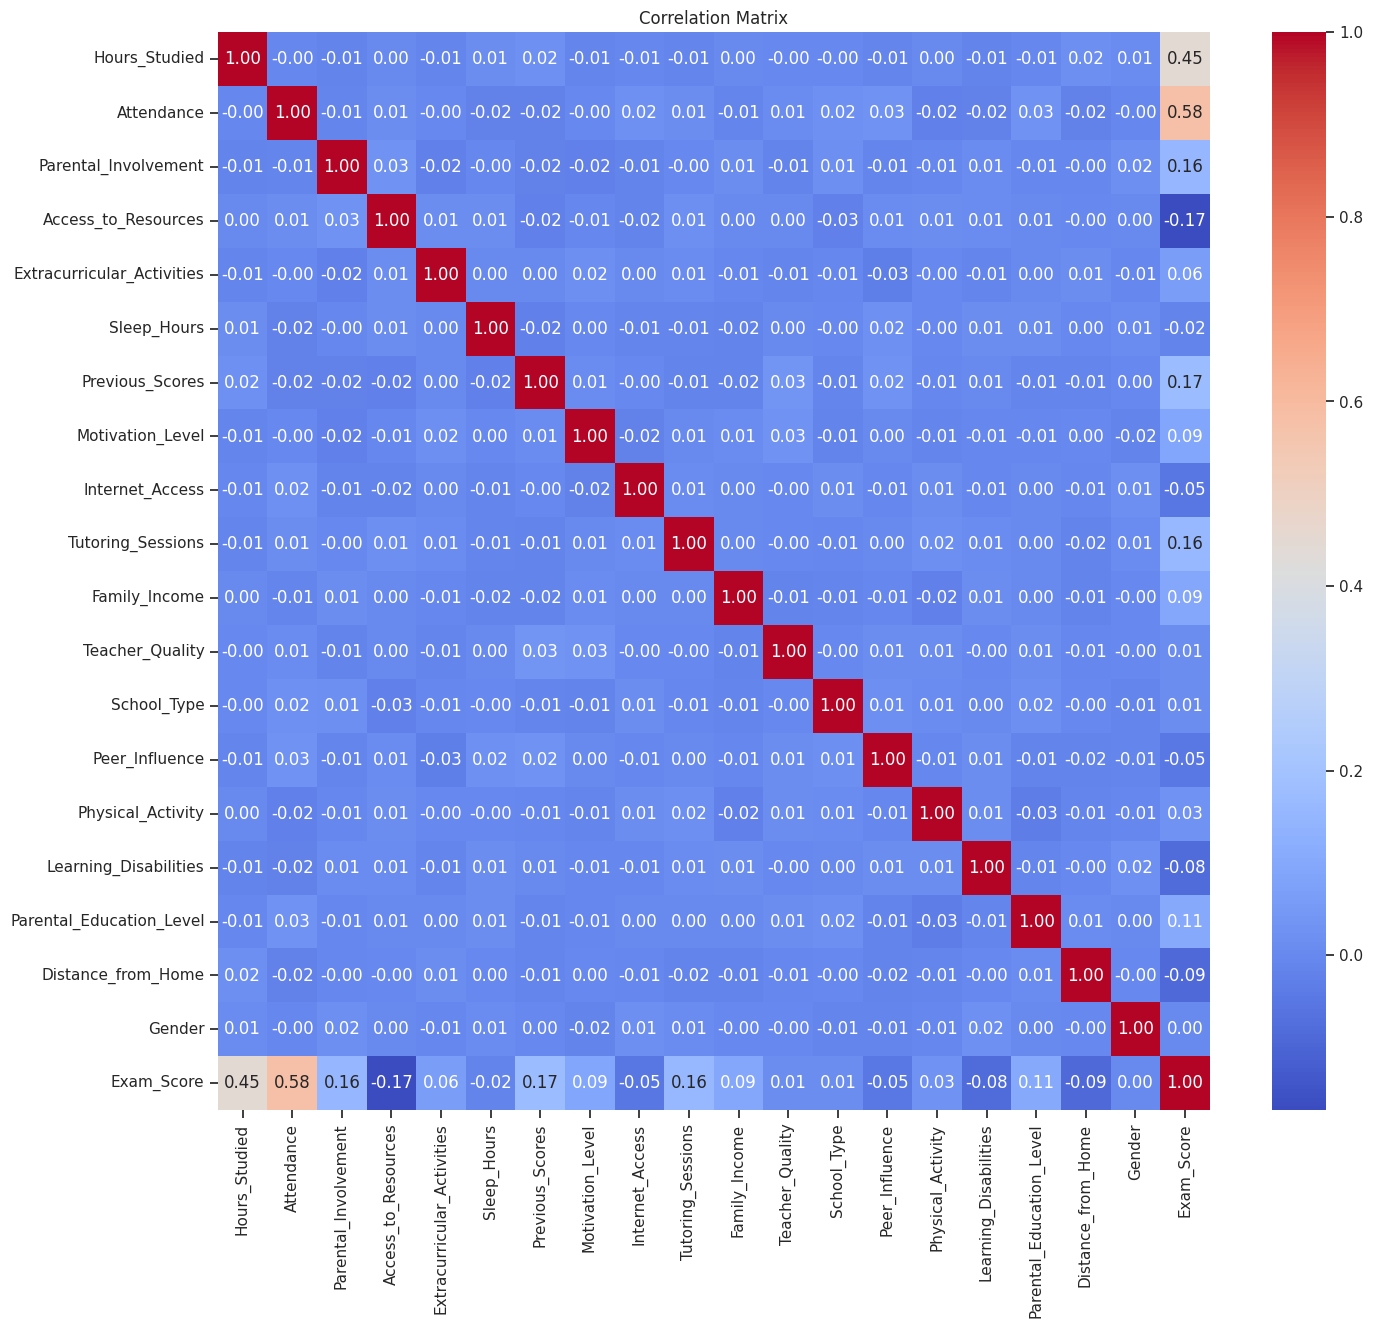

In [ ]:
# Select all relevant columns (including Exam_Score)
columns_for_correlation = ['Hours_Studied', 'Attendance', 'Parental_Involvement',
                          'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours',
                          'Previous_Scores', 'Motivation_Level', 'Internet_Access',
                          'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality',
                          'School_Type', 'Peer_Influence', 'Physical_Activity',
                          'Learning_Disabilities', 'Parental_Education_Level',
                          'Distance_from_Home', 'Gender', 'Exam_Score']

# Calculate the correlation matrix
corr_matrix = df[columns_for_correlation].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(16, 14))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Pair Grid

While the pair grid analysis supports some observations from the correlation matrix, it also reveals some interesting discrepancies. The correlation matrix indicates that Hours_Studied (0.45) and Attendance (0.58) have the strongest positive correlations with Exam_Score, suggesting they are important predictors. However, the pair grid suggests that Previous_Scores might have a stronger association with Exam_Score than Attendance, even though its correlation coefficient (0.17) is lower.

This discrepancy highlights the importance of considering both the strength of the linear relationship (correlation) and the visual patterns in the data (pair grid). Additionally, the pair grid reveals potential non-linearity in some relationships, such as the relationship between Hours_Studied and Exam_Score. This non-linearity suggests that factors beyond simple study time contribute to exam performance.  Furthermore, the pair grid highlights clusters of students with similar characteristics, including high previous scores, attendance, and parental involvement. These clusters suggest that a combination of factors may drive exam success.

To further analyze these relationships and investigate potential non-linearity and clustered behaviors, regression models will be developed. Additionally, any identified outliers will be examined to understand their deviation from general patterns.

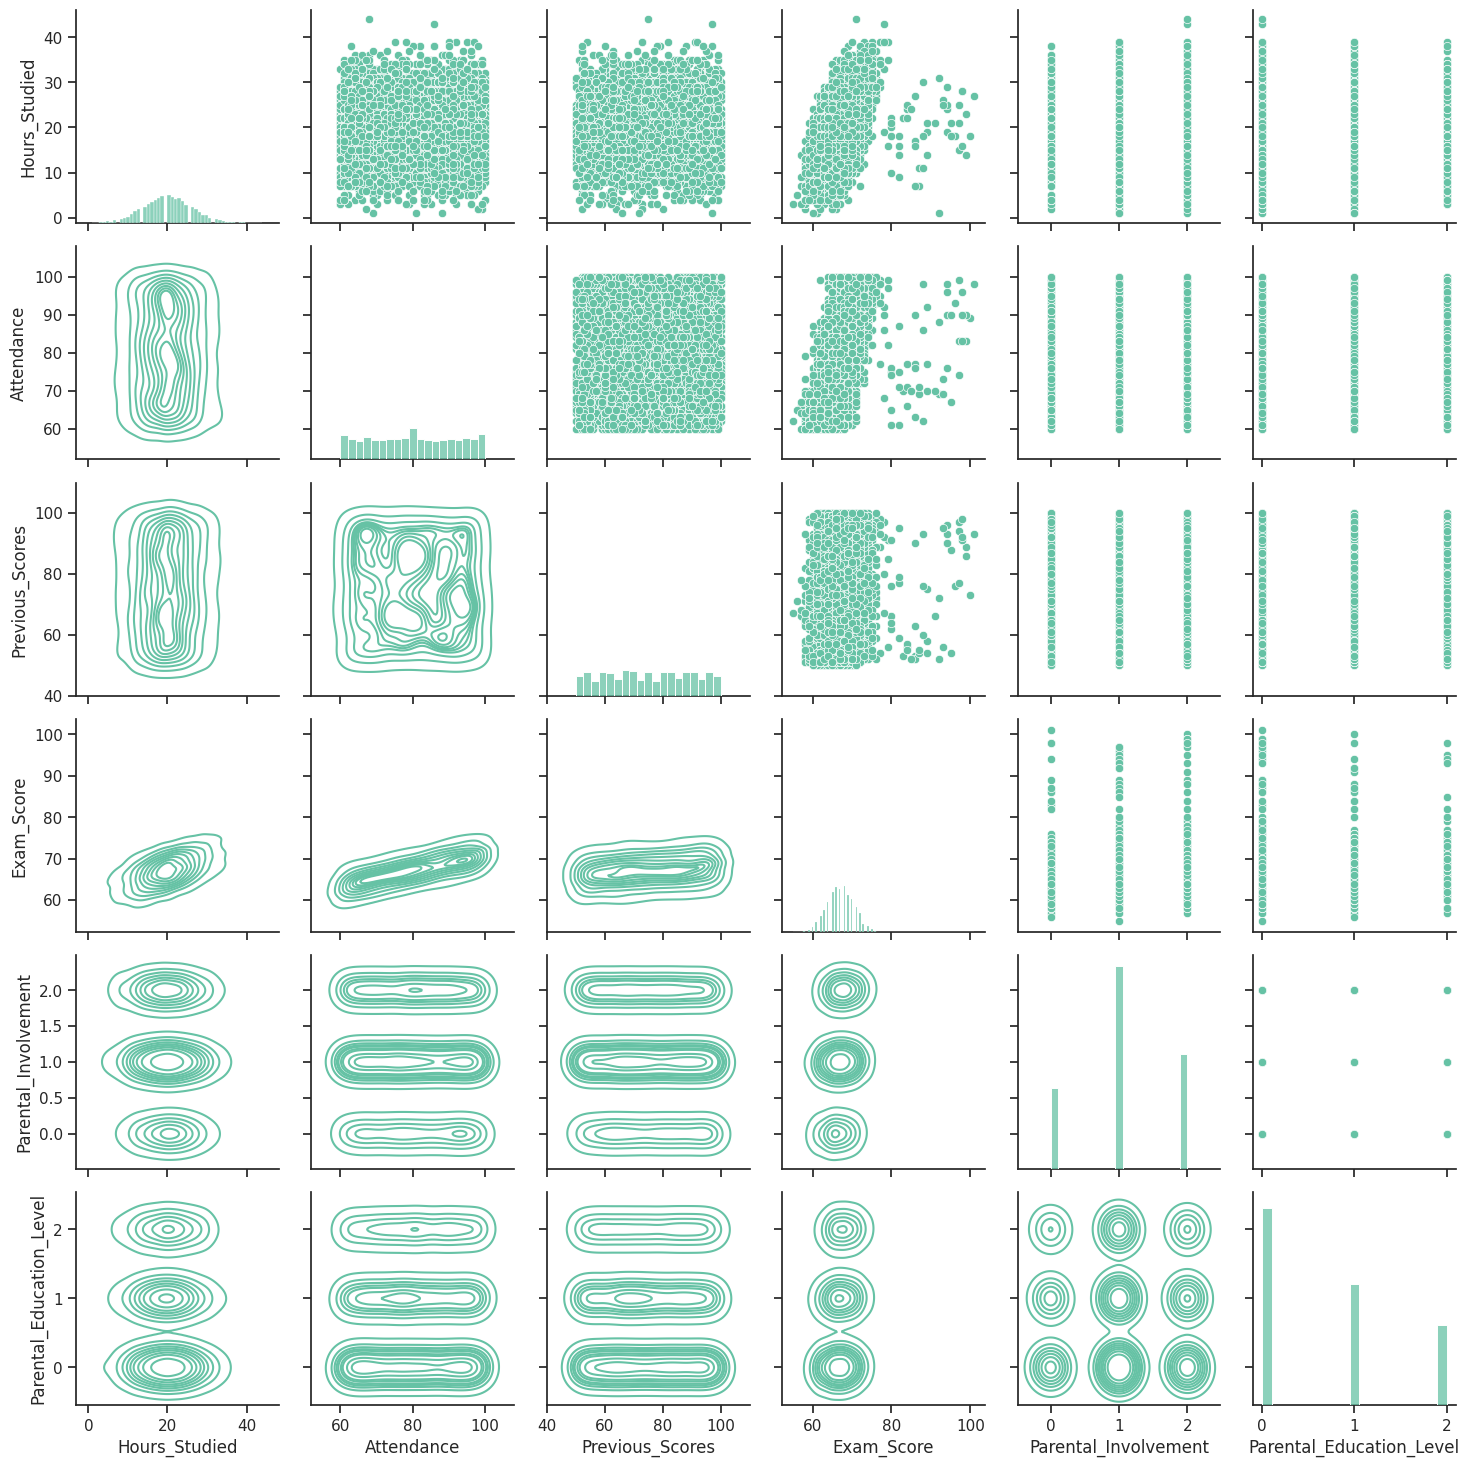

In [ ]:
# Select the columns for the pair plot
columns_for_pairgrid = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score', 'Parental_Involvement', 'Parental_Education_Level']

# Create the pair plot
g = sns.PairGrid(df[columns_for_pairgrid])

# Define the type of plot for the upper triangle
g.map_upper(sns.scatterplot)

# Define the type of plot for the diagonal
g.map_diag(sns.histplot)

# Define the type of plot for the lower triangle
g.map_lower(sns.kdeplot)

# Display the plot
plt.show()

### Distributions and QQ Plots

To further investigate the relationships identified in the correlation matrix and pair grid, I'll examine the distributions and Q-Q plots of several key variables, including Hours_Studied, Parental_Involvement, Attendance, Previous_Scores, Tutoring_Sessions, and Parental_Education_Level. The correlation matrix revealed positive correlations between these variables and Exam_Score, suggesting potential predictive relationships. By exploring their distributions and Q-Q plots, I aim to assess their normality and identify any potential outliers or unusual patterns that might influence the relationship with exam performance. This deeper dive will provide a more comprehensive understanding of these variables and inform the selection of appropriate statistical models for further analysis.

#### Continuous Variables

Continuous variables are those that can take on any value within a given range. In this dataset,  Hours_Studied, Previous_Scores, Attendance, and Exam_Score are treated as continuous variables, and their distributions are visualized using histograms and Q-Q plots.

In [ ]:
# create function for distribution and qq plots
def plot_distribution_and_qq(data, column_name, bins=30):
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))

  # Histogram
  sns.histplot(data[column_name], bins=bins, kde=True, ax=axes[0])
  axes[0].set_title(f"Distribution of {column_name}")

  # Q-Q plot
  sm.qqplot(data[column_name], line='s', ax=axes[1])
  axes[1].set_title(f"Q-Q Plot for {column_name}")

  plt.tight_layout()
  plt.show()

Observing the distribution and Q-Q plot for Exam_Score reveals an approximate normal distribution with a slight right skew. This suggests that most students scored around the average in the 70s, with a few students achieving significantly higher scores, contributing to the skew. To address this, I'll explore data transformations to reduce the skew and investigate potential outliers that may be influencing the distribution.

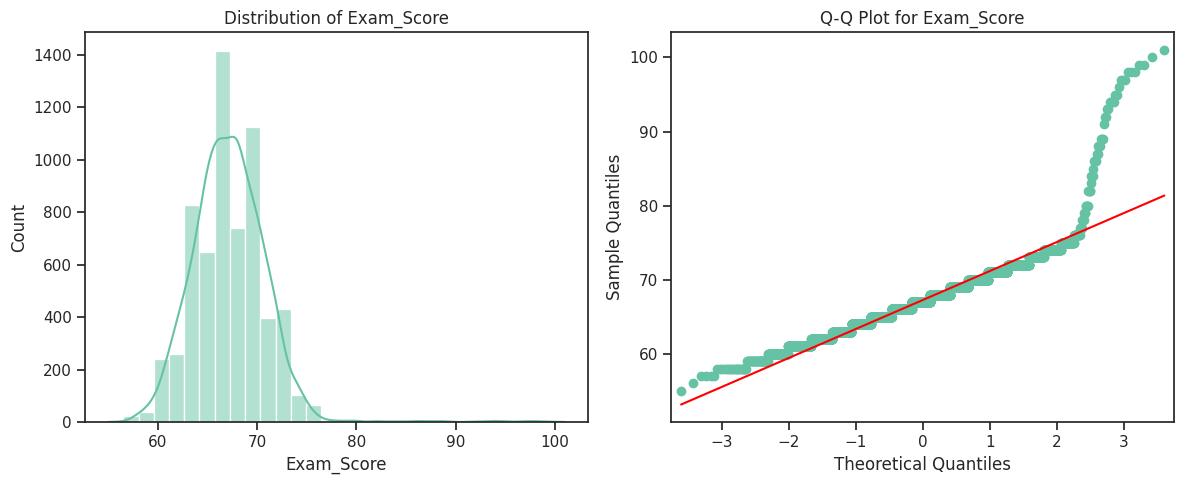

In [ ]:
plot_distribution_and_qq(df, 'Exam_Score')

Observing the distribution and Q-Q plot for Attendance reveals a non-normal distribution with multiple peaks and clustering around specific attendance percentages. This suggests that attendance is not evenly distributed and might be influenced by underlying factors. To address this, I'll consider non-parametric tests and transformations and will further investigate the factors contributing to these attendance patterns.

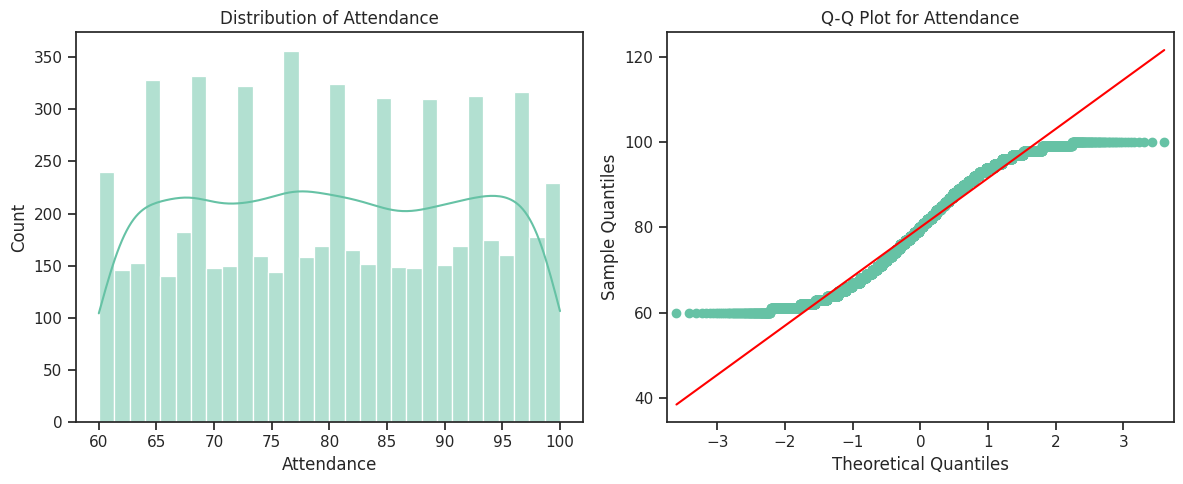

In [ ]:
plot_distribution_and_qq(df, 'Attendance')

Observing the distribution and Q-Q plot for Hours_Studied indicates an approximate normal distribution with a slight left skew. This suggests that most students study around the average of 20-25 hours, with a few students studying significantly fewer hours, contributing to the skew. To address this, I'll consider exploring data transformations to reduce the skew and investigate potential outliers that may be influencing the distribution.

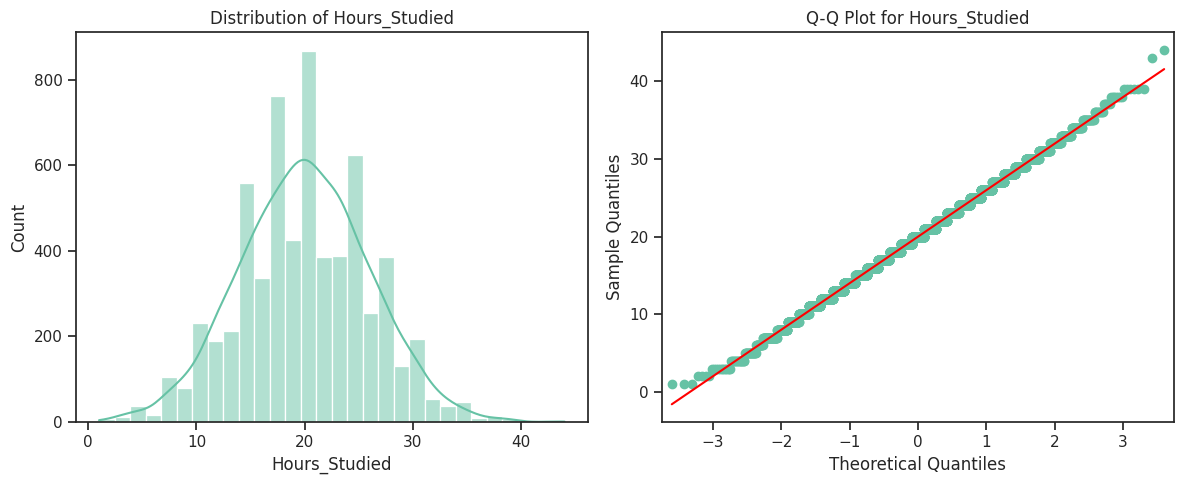

In [ ]:
plot_distribution_and_qq(df, 'Hours_Studied')

Observing the distribution and Q-Q plot of Previous_Scores indicate a non-normal distribution with some clustering around specific values. This suggests that previous scores are not evenly distributed across the range, and underlying factors may be influencing their distribution. To address this, I will consider non-parametric tests and transformations and will further investigate the factors contributing to these patterns.

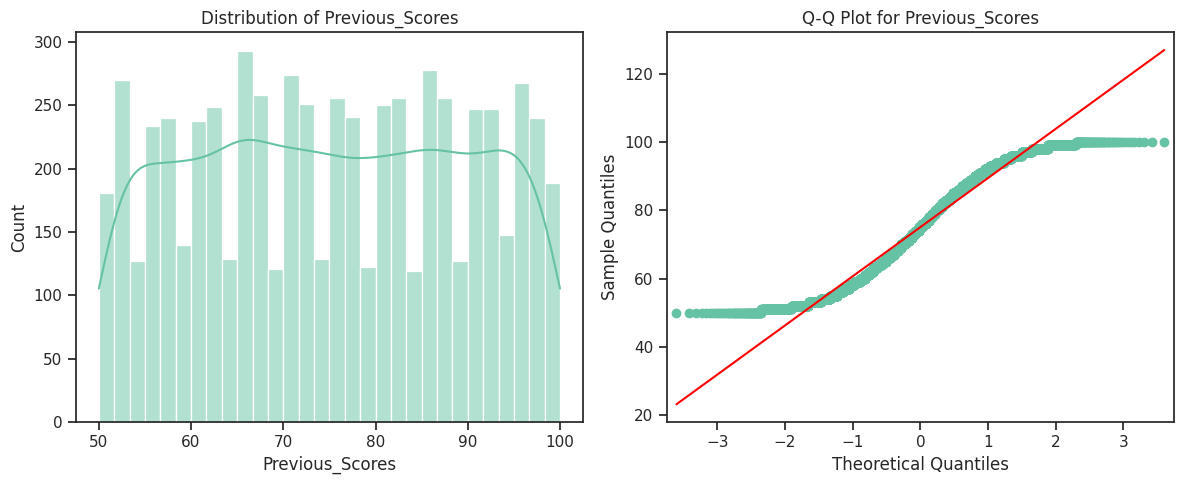

In [ ]:
plot_distribution_and_qq(df, 'Previous_Scores')

#### Discrete Variable Frequencies

Discrete variables can only take on specific, distinct values. In this dataset, Tutoring_Sessions, Parental_Involvement, and Parental_Education_Level are treated as discrete variables, and their distributions are visualized as bar charts.

In [ ]:
# Creates a bar chart to visualize the distribution of a discrete variable
def create_bar_chart(df, x_col, x_label, title):
  sns.set_theme(style="whitegrid")

  # Create the bar chart
  ax = sns.countplot(x=x_col, data=df, color='mediumaquamarine')

  # Set labels and title
  ax.set_xlabel(x_label)
  ax.set_ylabel('Count')
  ax.set_title(title)

  # Show the plot
  plt.show()

The bar chart titled 'Distribution of Tutoring Sessions' displays the number of students who attended different numbers of tutoring sessions. The bars for 0, 1, and 2 sessions are the tallest, indicating that most students had few or no sessions. As the number of sessions increases, the number of students attending those sessions decreases. As we explore the relationship between student exam performance and tutoring sessions, we could potentially investigate the factor of whether there was greater improvement from previous scores.

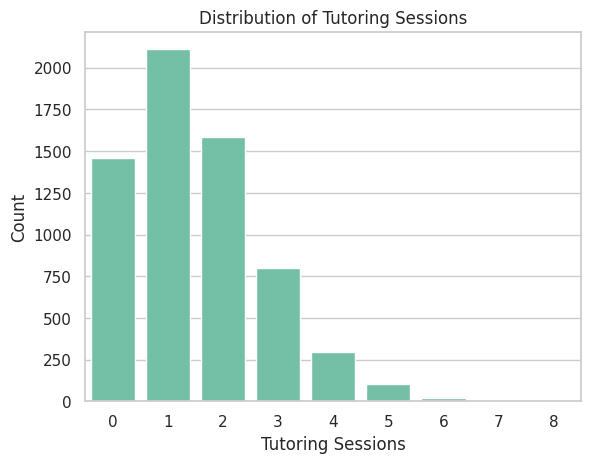

In [ ]:
create_bar_chart(df, 'Tutoring_Sessions', 'Tutoring Sessions', 'Distribution of Tutoring Sessions')

The 'Distribution of Parental Involvement bar chart reveals that most students have a medium level of parental involvement, with fewer students at the low and high extremes. As we explore the relationship between student exam performance and parental involvement, we could investigate factors such as parental education level, family income, and access to resources.

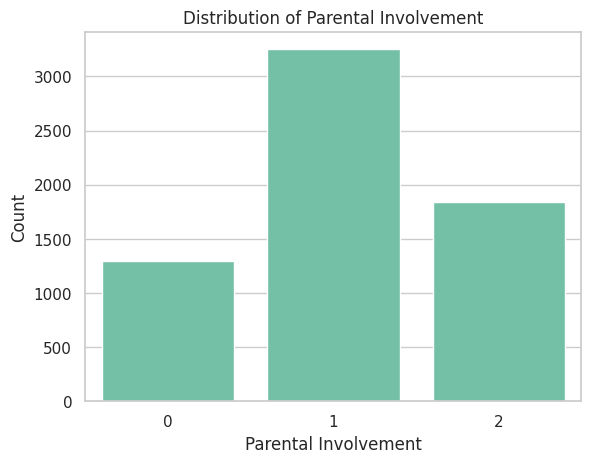

In [ ]:
create_bar_chart(df, 'Parental_Involvement', 'Parental Involvement', 'Distribution of Parental Involvement')

The 'Distribution of Parental Education Level' bar chart reveals that most parents have a high school education, with fewer parents having college or postgraduate degrees. As we explore the relationship between student exam performance and parental education level, we could investigate factors such as family income and access to resources.

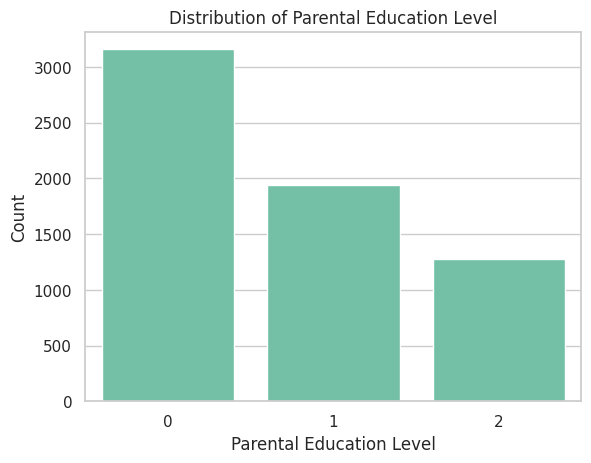

In [ ]:
create_bar_chart(df, 'Parental_Education_Level', 'Parental Education Level', 'Distribution of Parental Education Level')

### Identifying Patterns and Outliers

The analysis of scatterplots, boxplots and facet plots reveal that multiple factors, including study habits, attendance, previous academic performance, and parental involvement, can influence exam scores. Additionally, the presence of outliers in these visualizations highlights individual learning styles and performance variations, where some students excel despite challenges while others struggle even with apparent advantages.  Further investigation of these outliers may provide valuable insights into the complex interplay of factors affecting student success.

#### Scatterplots

To enhance the readability of these scatterplots, I adjusted the size and transparency of the data points. I used a small point size and an alpha value of 0.2 to reduce visual clutter and allow for better visualization of data point density, especially in areas with significant overlap. This transparency helps to perceive the concentration of students with different combinations of study hours, previous scores and attendance.

Also, there is a clear positive correlation between exam scores and hours studied, indicating that students who dedicate more time to studying tend to achieve higher scores. However, some outliers exist. A few students with low study hours achieved high scores, suggesting they may be efficient learners or possess prior solid knowledge. Conversely, some students with high study hours had low scores, possibly indicating inefficient study habits or other hindering factors.

While attendance also positively correlates with exam performance, the relationship is less strong than with study time. Outliers in this data suggest that while some students with low attendance still achieved high scores, others struggled, highlighting the potential need for additional support or different learning strategies. As expected, previous scores demonstrate a strong positive correlation, confirming that past academic performance often predicts current performance.

Interestingly, some students with low previous scores significantly improved on this exam, while others with high scores performed lower. This variability could be attributed to changes in study habits, effort levels, or external factors influencing their performance which we will further investigate.

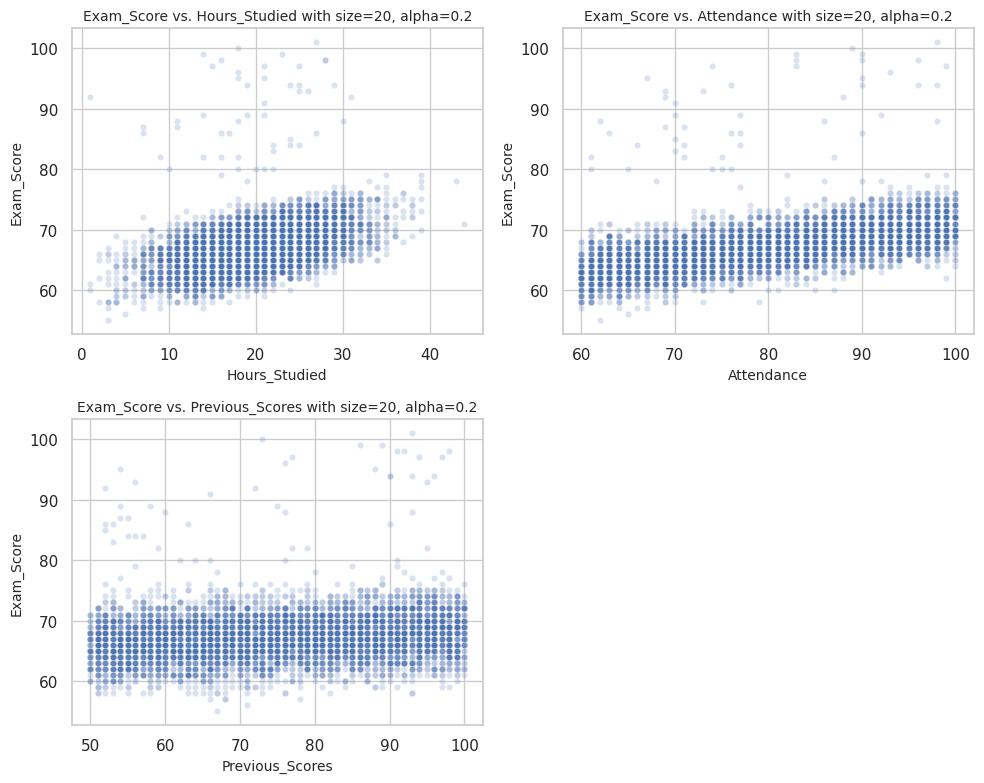

In [ ]:
# creates a grid of scatterplots with varying sizes and alphas
def create_comparison_scatterplots(df, x_cols, y_col, sizes, alphas, hue=None):
    num_plots = len(x_cols)
    num_rows = (num_plots + 1) // 2
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
    axes = axes.flatten()

    for i, (x_col, size, alpha) in enumerate(zip(x_cols, sizes, alphas)):
        ax = axes[i]
        sns.scatterplot(x=x_col, y=y_col, hue=hue, data=df,
                        s=size, alpha=alpha, ax=ax)
        ax.set_title(f'{y_col} vs. {x_col} with size={size}, alpha={alpha}', fontsize=10)
        ax.set_xlabel(x_col, fontsize=10)
        ax.set_ylabel(y_col, fontsize=10)

    if num_plots < len(axes):
        for j in range(num_plots, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

sizes = [20, 20, 20]
alphas = [0.2, 0.2, 0.2]
create_comparison_scatterplots(df,
                              ['Hours_Studied', 'Attendance', 'Previous_Scores'],
                              'Exam_Score',
                              sizes,
                              alphas)

#### Box Plots

The boxplots illustrate how exam scores relate to tutoring sessions, parental involvement, and parental education level.  Regarding tutoring, the median exam score appears to increase slightly with the number of sessions, suggesting a potential positive impact. However, outliers exist, particularly in groups with fewer sessions, indicating that some students perform exceptionally well or poorly regardless of tutoring.

When examining parental involvement, median exam scores across different levels appear relatively similar.  However, the "high involvement" group shows a slightly higher median and a wider range of scores.  Outliers are present in all groups, suggesting that parental involvement alone may not fully explain variations in exam performance.

Finally, there is no clear trend in exam scores based on parental education level.  Again, outliers are present across all groups, indicating that parental education level alone does not fully account for variations in exam performance.

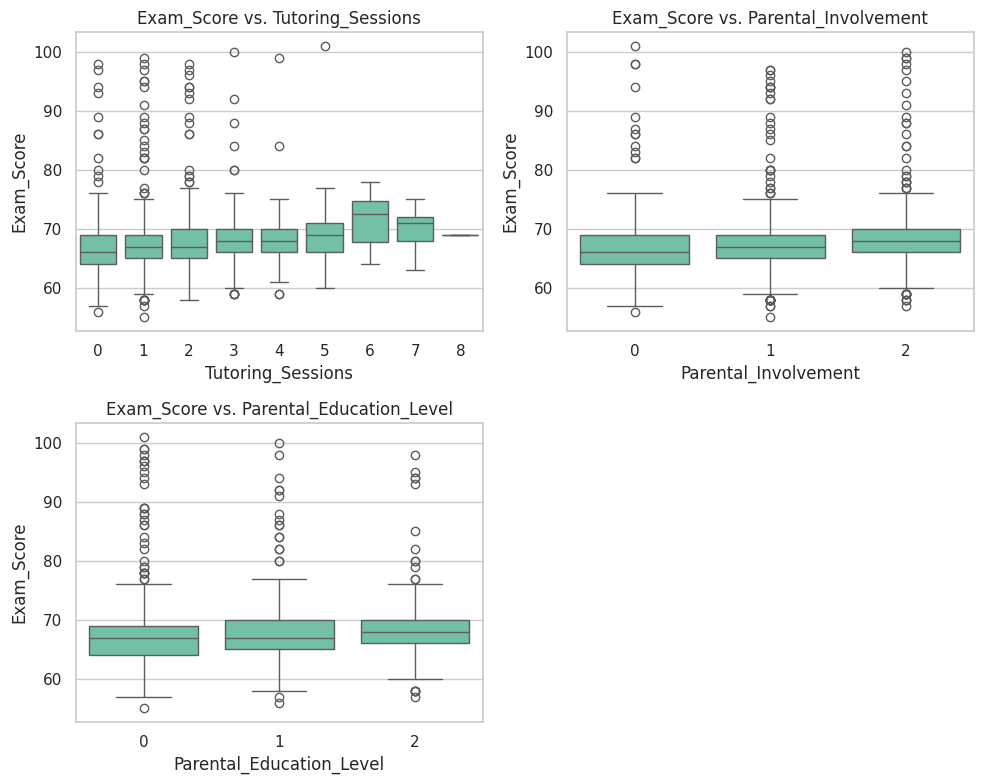

In [ ]:
# Creates a figure with multiple boxplots comparing a list of variables

def create_comparison_boxplots(df, x_cols, y_col):
    num_plots = len(x_cols)
    num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed
    num_cols = 2  # Two columns per row

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easier iteration

    for i, x_col in enumerate(x_cols):
        ax = axes[i]
        sns.boxplot(x=x_col, y=y_col, data=df, ax=ax, color='mediumaquamarine')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f'{y_col} vs. {x_col}')

    # Remove any extra subplots if the number of plots is odd
    if num_plots < len(axes):
        for j in range(num_plots, len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_comparison_boxplots(
    df,
    ['Tutoring_Sessions', 'Parental_Involvement', 'Parental_Education_Level'],
    'Exam_Score'
)

#### Facet Plots

Facet plots are a powerful tool for visualizing multi-dimensional relationships in data, allowing us to move beyond simple scatter plots or box plots by introducing additional categorical variables. They create a series of subplots, each showing the relationship between two variables, but broken down by the categories of a third variable. This helps us see how the relationship might change across different groups or conditions.

For example, in the plots below, we'll explore the relationships between several variables and exam scores, incorporating categorical variables like Parental_Involvement, Tutoring_Sessions, and Parental_Education_Level to see how these factors influence student performance.  We'll even use a 'hue' parameter in one of the plots to introduce a fourth variable, Attendance, and examine its interplay with the other factors.

By using facet plots, we can uncover complex interactions and conditional relationships that might not be apparent in simpler visualizations. This allows us to gain a richer and more nuanced understanding of the factors that contribute to student success.

In [ ]:
#creates a FacetGrid plot with optional hue parameter

def create_facet_plot(df, x_col, y_col, facet_col, hue_col=None, col_wrap=2, height=5):
  g = sns.FacetGrid(df, col=facet_col, hue=hue_col, col_wrap=col_wrap, height=height)
  g.map(sns.scatterplot, x_col, y_col)
  g.add_legend()
  g.set_axis_labels(x_col, y_col)
  plt.show()

This facet plot explores the relationship between Hours_Studied and Exam_Score, considering different levels of Parental_Involvement. Across all levels, a generally positive relationship exists: students who study more tend to achieve higher exam scores. However, the strength of this relationship varies. When parental involvement is low, the correlation appears weaker, and the data points are more scattered, suggesting that other factors like individual motivation or access to resources play a more significant role.

As Parental Involvement increases, the data points become more clustered, and the positive trend becomes clearer. This suggests parental support reinforces the importance of studying and contributes to more consistent academic performance. It's interesting to see how the visual patterns in the plot change across the different levels of parental involvement, highlighting the potential influence of parental support on study habits and exam scores.

Despite these general trends, individual differences are still evident. Within each level of parental involvement, some students achieve high scores with less study time, while others require more effort to reach the same level. This variability underscores the importance of considering individual learning styles and needs when evaluating student performance.

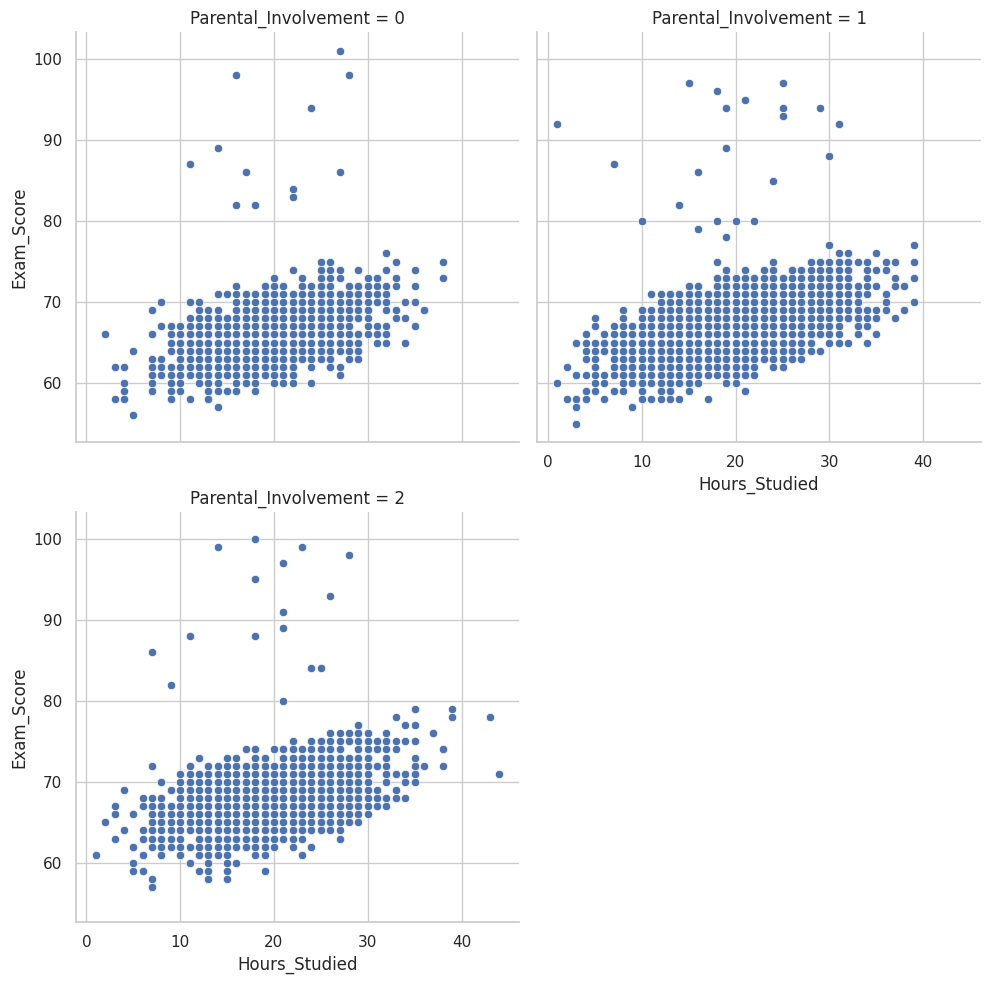

In [ ]:
create_facet_plot(df, "Hours_Studied", "Exam_Score", "Parental_Involvement")

This facet plot examines the relationship between Previous_Scores and Exam_Score, considering the number of Tutoring_Sessions students received. Across all levels of tutoring, there's a clear positive relationship: students with higher previous scores tend to achieve higher exam scores. This suggests that past academic performance is a good predictor of future performance, regardless of the amount of tutoring received.

However, it's worth noting that the number of data points decreases as the number of tutoring sessions increases. This indicates that fewer students received higher levels of tutoring. Despite this, the consistent positive relationship suggests that students generally perform well regardless of how much tutoring they receive.

Looking closer, there are subtle variations in the strength and variability of the relationship across the different facets. This hints that tutoring might influence exam scores, although the effect may not be uniform across all students or tutoring levels. Further analysis could explore whether tutoring significantly impacts specific groups of students, such as those with lower previous scores or those who demonstrate a greater need for academic support.

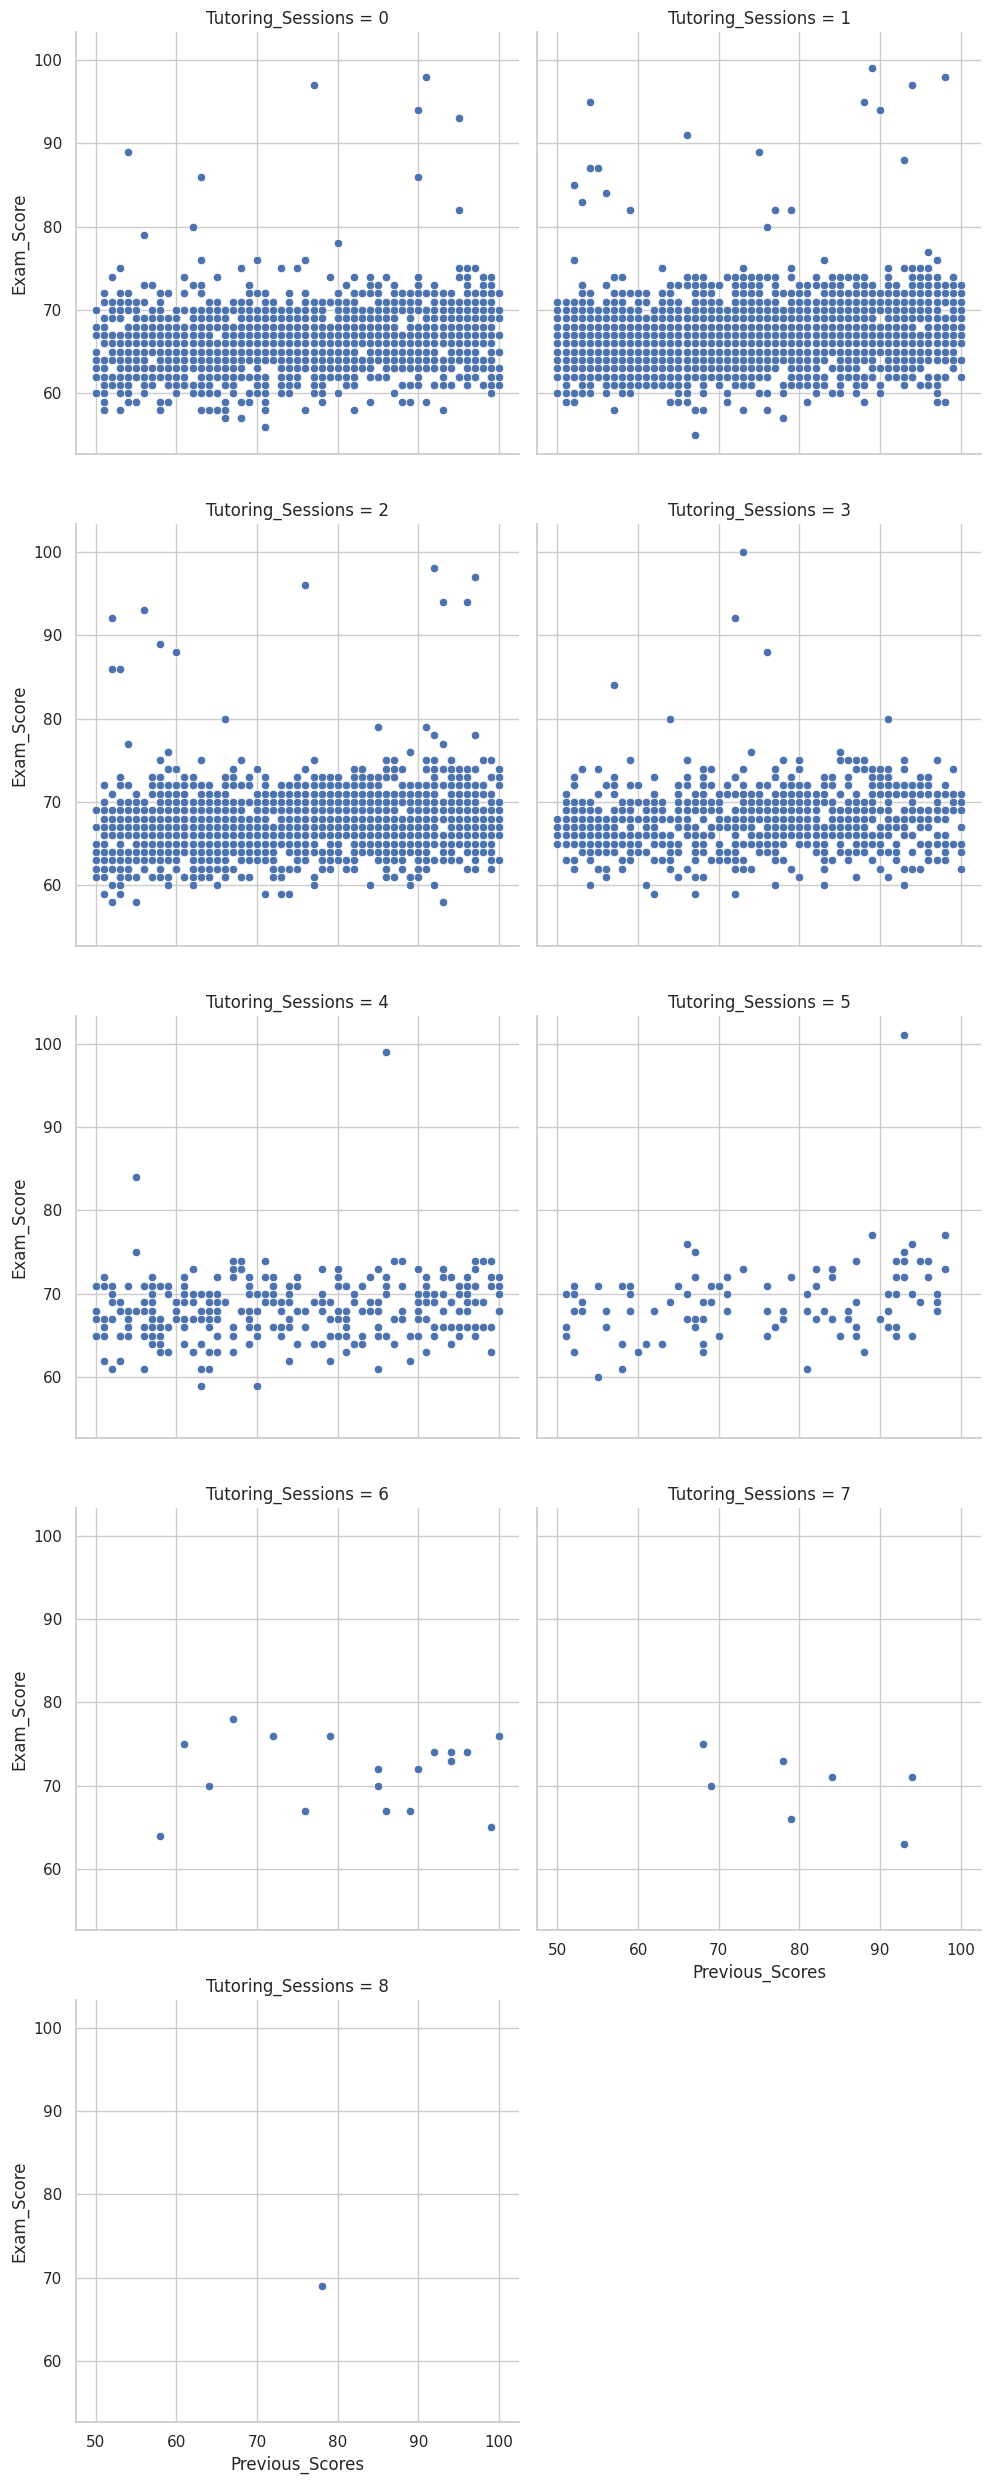

In [ ]:
create_facet_plot(df, "Previous_Scores", "Exam_Score", "Tutoring_Sessions")

This facet plot examines the relationship between Attendance and Exam_Score, considering different levels of Parental_Education_Level. There's a clear positive relationship across all levels of parental education: students with higher attendance tend to have higher exam scores. This suggests that consistent class participation is essential for academic success, regardless of parental education level.

While we can't definitively say that parental education directly causes differences in the relationship between attendance and exam scores, the plot does reveal some interesting trends. Parental education indirectly influences factors like student motivation, study habits, or access to resources, which could affect attendance and exam performance.

Further analysis, including statistical tests and potentially gathering qualitative data, could help explore the complex interplay between these variables and shed more light on the role of parental education in student success.

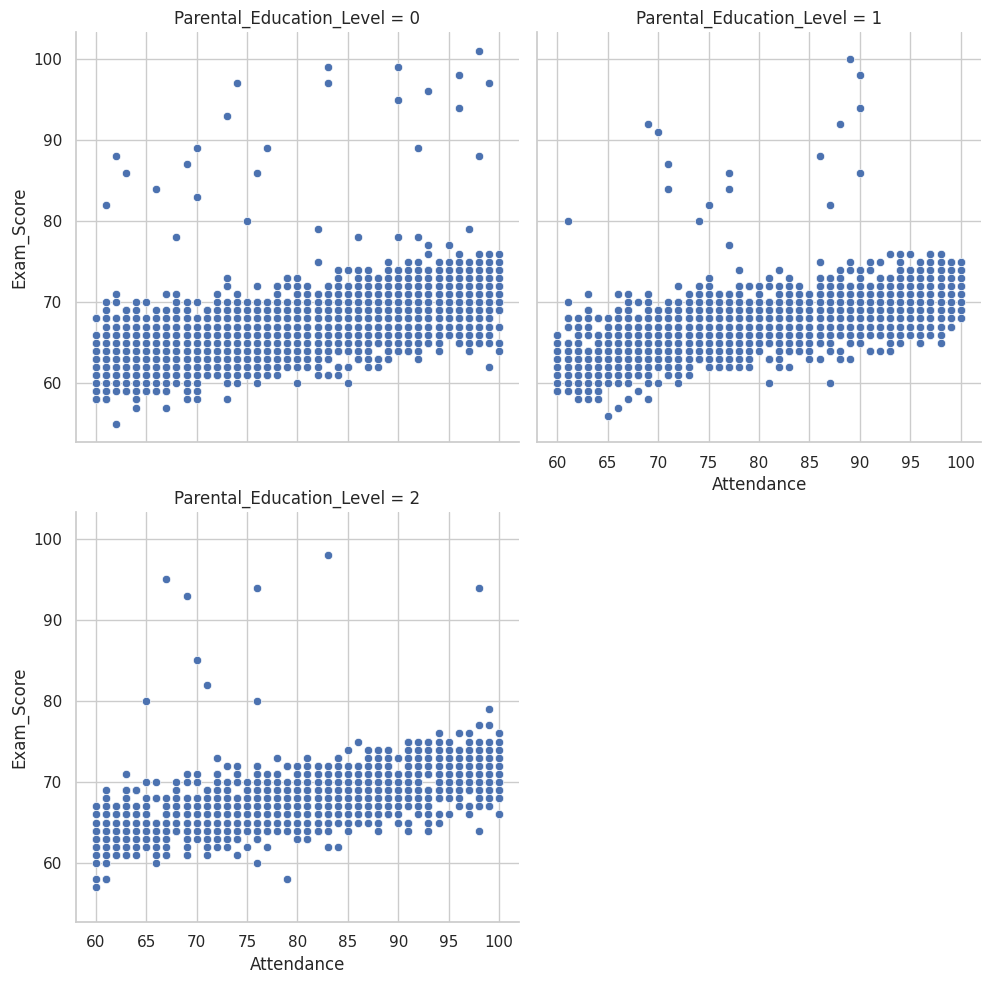

In [ ]:
create_facet_plot(df, "Attendance", "Exam_Score", "Parental_Education_Level")

This facet plot visually represents the relationship between Hours_Studied and Exam_Score, with separate plots for different levels of Parental_Involvement.  The plot also uses color (hue) to describe various levels of Attendance, allowing us to explore the interplay of these three variables.

A key observation is the positive relationship between Hours_Studied and Exam_Score across all levels of parental involvement.  This suggests that dedicating more time to studying generally leads to better exam performance, regardless of the level of parental support.  Additionally, the color gradient reveals a positive association between attendance and exam scores, indicating that students who attend class more frequently tend to achieve higher scores.

This visualization effectively highlights the multifaceted nature of student performance, demonstrating how factors like study habits, Attendance, and parental involvement can interact to influence academic outcomes.

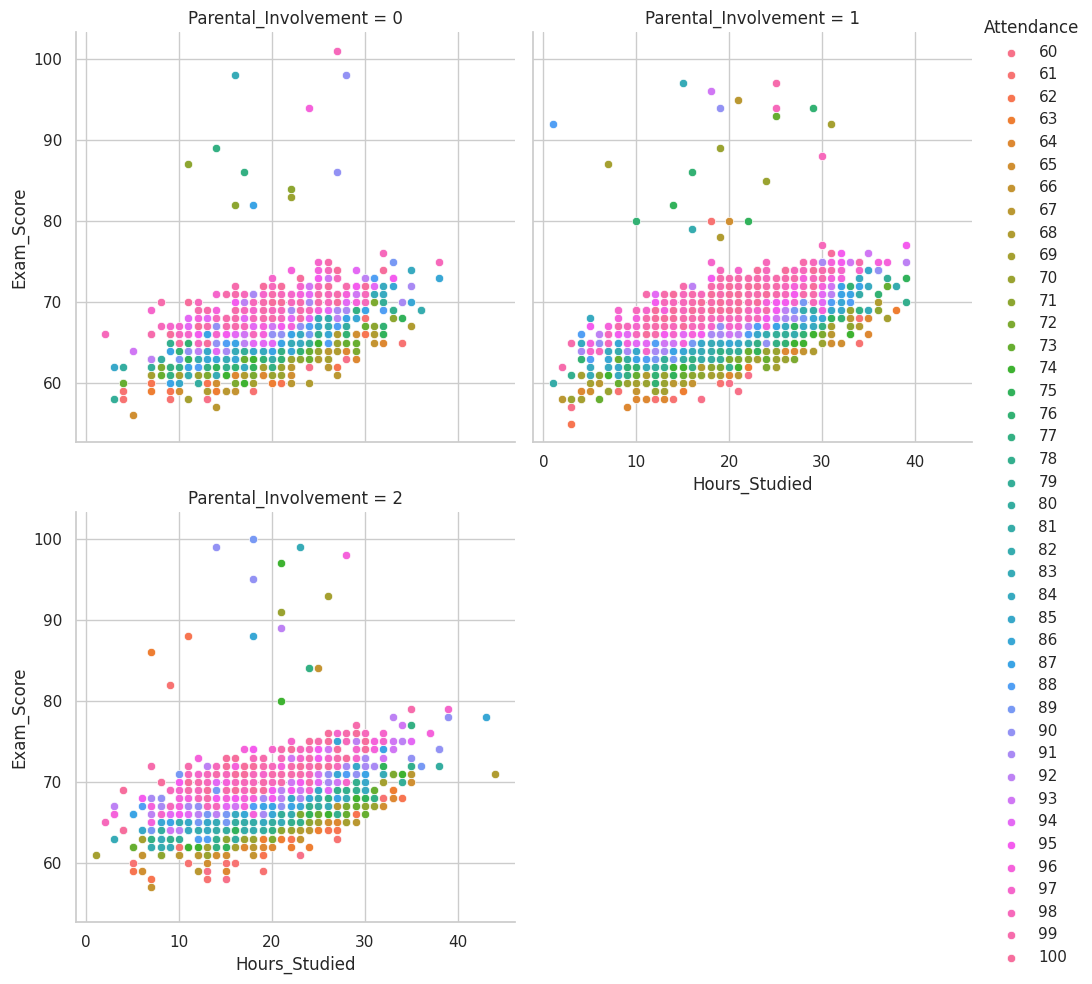

In [ ]:
create_facet_plot(df, "Hours_Studied", "Exam_Score", "Parental_Involvement", hue_col="Attendance")

### Log Transformation

Given that my models will use 'Exam_Score' as the dependent variable, I first examined its distribution.  The original scores exhibited a slight right skew, potentially violating the normality assumption of many statistical models. To address this, I applied a log transformation, which is often effective in reducing right skew and bringing the data closer to a normal distribution.  As expected, the transformed distribution became more symmetrical and closer to normal. This preliminary analysis will inform my model selection process.

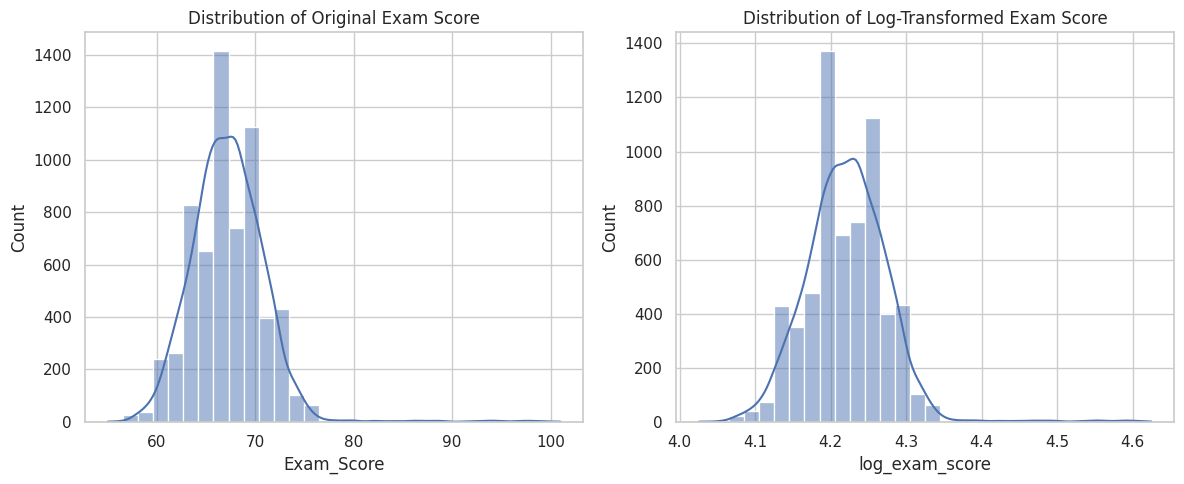

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Exam Score histogram
sns.histplot(df['Exam_Score'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Original Exam Score")

# Log-transformed Exam Score histogram
df['log_exam_score'] = np.log(df['Exam_Score'] + 1)  # Add 1 to handle potential zeros
sns.histplot(df['log_exam_score'], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Log-Transformed Exam Score")

plt.tight_layout()
plt.show()

### Modeling The Response Variable

To model the response variable (exam scores), a multi-faceted approach combining several statistical techniques will be employed. Initially, Ordinary Least Squares (OLS) regression will explore the relationship between exam performance and various predictors, including hours studied, previous scores, parental involvement, parental education level, tutoring sessions, and attendance.

Exploratory data analysis (EDA) will help visualize relationships and identify potential interactions between variables, using plots to uncover patterns and outliers. The assumptions of OLS regression, such as linearity, normality of residuals, homoscedasticity (constant variance of errors), and multicollinearity, will be assessed. If heteroscedasticity (non-constant variance) is detected, transformations or robust regression techniques will be considered.

In addition to OLS, Logistic Regression will model binary outcomes, such as pass or fail classifications based on exam scores. This method predicts probabilities and identifies key predictors influencing the likelihood of passing. Model performance will be evaluated using metrics like accuracy, precision, recall, and F1-score, alongside cross-validation to ensure generalizability. Visualizations, such as histograms of predicted probabilities and plots of predictor relationships, will aid interpretation and refinement.

Bayesian models will be explored to incorporate prior knowledge, such as the relationship between exam scores and previous academic performance. These models provide a probabilistic framework to handle uncertainty and leverage prior distributions for robust parameter estimates. Posterior distributions will offer insights into the most likely parameter values and their credible intervals, allowing for a nuanced understanding of predictor impacts, particularly when sample sizes are small or variability is high.

Building on this, Hierarchical Bayesian models will account for group-level effects, such as differences in exam performance across parental education levels. These models capture both population-level effects and group-specific deviations, offering a comprehensive view of how predictors affect exam scores across different groups. This structure is particularly valuable for understanding nested or hierarchical data while quantifying uncertainty at multiple levels.

For count data, such as the number of days attended, Poisson regression will analyze its influence on exam scores. This technique is ideal for non-negative count variables that follow a Poisson distribution. If overdispersion (variance exceeding the mean) is detected, alternative models like Negative Binomial regression will be considered. Visualizations, including predicted attendance versus predictors and residual plots, will evaluate model fit and guide refinements.

Model validation and residual analysis will ensure the robustness and reliability of findings. Cross-validation and residual diagnostics will help identify patterns or deviations from model assumptions. By integrating these techniques, the goal is to identify the most influential predictors of exam performance, understand their interactions, and develop a reliable predictive model for student outcomes.

### Ordinary Least Squares (OLS) Regression Model

This section employs Ordinary Least Squares (OLS) regression to analyze and quantify the relationships between a dependent variable (e.g., exam scores) and one or more independent variables (e.g., hours studied, attendance). Guided by findings from the exploratory data analysis, four distinct OLS models were developed to explore how various factors influence student exam performance.

The first model incorporates a comprehensive set of predictors, including academic effort (Hours_Studied, Attendance), prior performance (Previous_Scores), external support (Tutoring_Sessions), and family background (Parental_Involvement, Parental_Education_Level). This model aims to capture the influence of all potentially relevant factors on exam scores.

The second model narrows its focus to academic effort and prior performance, excluding family-related factors. It isolates the effects of direct academic variables on exam outcomes. The third model introduces an interaction term between Hours_Studied and Attendance to evaluate whether the combination of studying and attendance produces a synergistic effect on performance, exploring potential nonlinear or conditional relationships. Finally, the fourth model combines academic effort with family background factors to assess how both individual and family-related influences contribute to exam scores.

By comparing these models, this analysis aims to uncover the relative importance of different predictor groups, identify any interaction effects, and evaluate the impact of excluding certain variables. These comparisons provide valuable insights into the factors that most significantly drive student exam performance.

In [ ]:
# Function to plot the distribution of residuals
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ## Plot a histogram
    sns.histplot(resids, bins=20, kde=True, ax=ax[0])
    ax[0].set_title('Histogram of Residuals')
    ax[0].set_xlabel('Residual Values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot=ax[1])
    ax[1].set_title('Q-Q Normal Plot of Residuals')
    plt.show()

# Function to plot residuals vs predicted values
def residual_plot(df, predicted='predicted', resids='resids'):
    fig, ax = plt.subplots(figsize=(12, 5))
    RMSE = np.std(df[resids])  # Standard deviation of residuals
    sns.scatterplot(x=predicted, y=resids, data=df, ax=ax)
    ax.axhline(0.0, color='red', linewidth=1.0)
    ax.axhline(2.0 * RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.axhline(-2.0 * RMSE, color='red', linestyle='dashed', linewidth=1.0)
    ax.set_title('Plot of Residuals vs. Predicted')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    plt.show()

In [ ]:
# Function to  train and test an OLS model with a specified formula and evaluate performance

def ols_train_test_split_and_evaluate(df, formula, test_size=0.2, random_state=42):

    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    # Fit the OLS model on the training set
    ols_model = smf.ols(formula, data=train_df).fit()

    # Predict on both train and test sets
    train_df['predicted'] = ols_model.predict(train_df)
    test_df['predicted'] = ols_model.predict(test_df)

    # Calculate residuals
    train_df['residuals'] = train_df['Exam_Score'] - train_df['predicted']
    test_df['residuals'] = test_df['Exam_Score'] - test_df['predicted']

    # Calculate error metrics
    train_mse = mean_squared_error(train_df['Exam_Score'], train_df['predicted'])
    test_mse = mean_squared_error(test_df['Exam_Score'], test_df['predicted'])
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(train_df['Exam_Score'], train_df['predicted'])
    test_mae = mean_absolute_error(test_df['Exam_Score'], test_df['predicted'])

    # Compile results
    results = {
        'model_summary': ols_model.summary(),
        'train_predictions': train_df[['Exam_Score', 'predicted', 'residuals']],
        'test_predictions': test_df[['Exam_Score', 'predicted', 'residuals']],
        'error_metrics': {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
        }
    }

    # Print model summary
    print(results['model_summary'])

    # Plot residual distribution and Q-Q plot
    plot_resid_dist(train_df['residuals'])

    # Plot residuals vs predicted values
    residual_plot(df)

    return results


#### Model 1 - Comprehensive Model


                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     1422.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:54:21   Log-Likelihood:                -11682.
No. Observations:                5102   AIC:                         2.338e+04
Df Residuals:                    5095   BIC:                         2.342e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

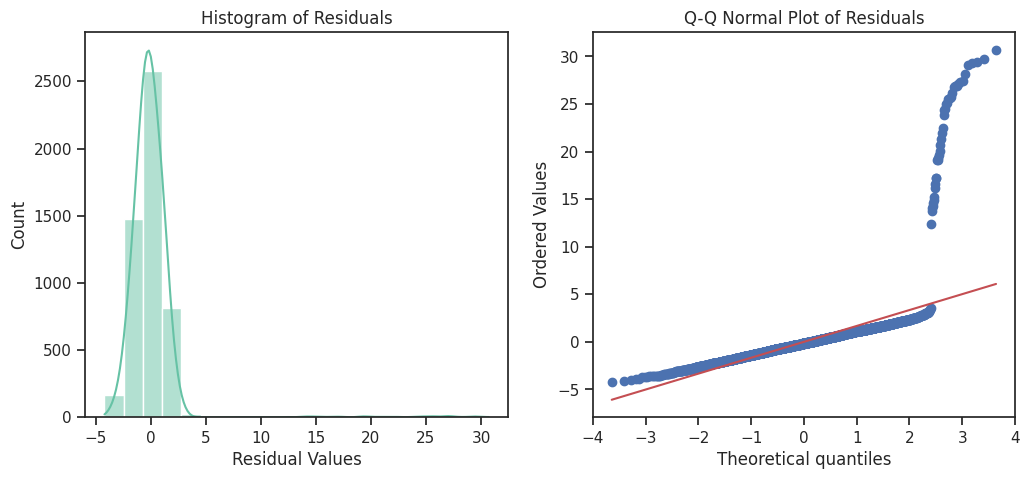

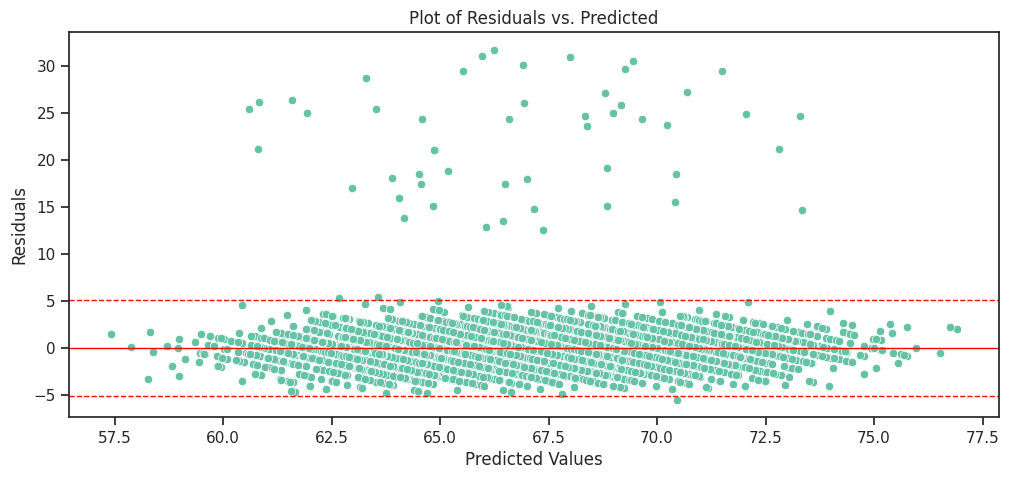

  Metric     Train      Test
0   RMSE  2.388662  2.329659
1    MAE  1.151085  1.128729


In [ ]:
formula = 'Exam_Score ~ Hours_Studied + Attendance + Previous_Scores + Tutoring_Sessions + Parental_Involvement + Parental_Education_Level'
results = ols_train_test_split_and_evaluate(df, formula)

# Error metrics as a dictionary
error_metrics = results['error_metrics']
# Convert the dictionary into a pandas DataFrame
metrics_df = pd.DataFrame(
    {
        'Metric': ['RMSE', 'MAE'],
        'Train': [error_metrics['train_rmse'], error_metrics['train_mae']],
        'Test': [error_metrics['test_rmse'], error_metrics['test_mae']]
    }
)

# Display the table
print(metrics_df)

# multiple model's metrics
models_metrics = {
    'Model 1': error_metrics
}


#### Model 2 - Academic Effort and Performance Model

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     1819.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:44:25   Log-Likelihood:                -11930.
No. Observations:                5102   AIC:                         2.387e+04
Df Residuals:                    5097   BIC:                         2.390e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            41.3280      0.33

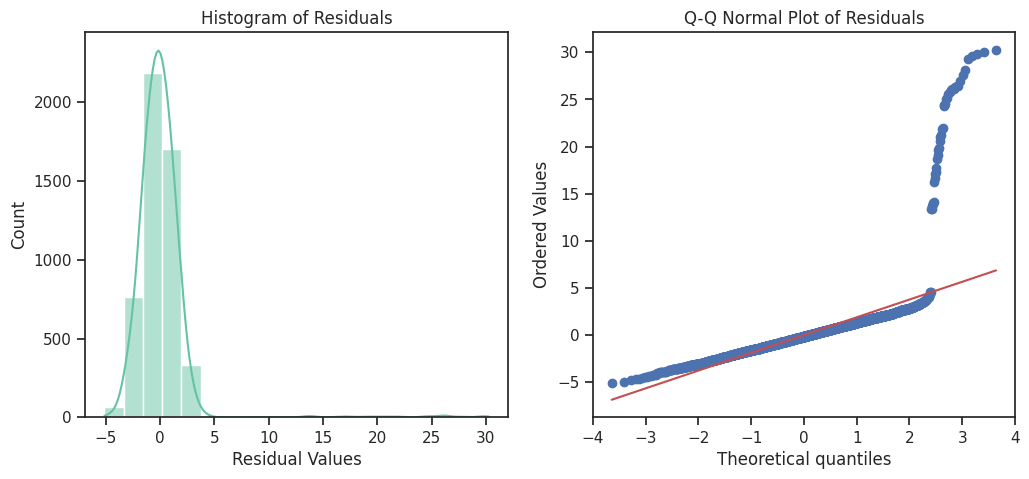

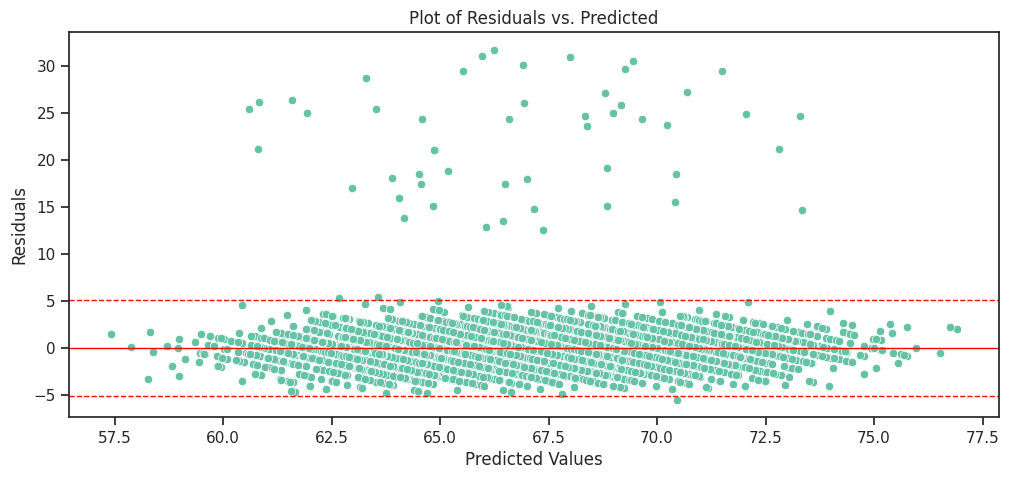

  Metric     Train      Test
0   RMSE  2.507568  2.463212
1    MAE  1.327386  1.329928


In [ ]:
formula = 'Exam_Score ~ Hours_Studied + Attendance + Previous_Scores + Tutoring_Sessions'
results = ols_train_test_split_and_evaluate(df, formula)

# Error metrics as a dictionary
error_metrics = results['error_metrics']
# Convert the dictionary into a pandas DataFrame
metrics_df = pd.DataFrame(
    {
        'Metric': ['RMSE', 'MAE'],
        'Train': [error_metrics['train_rmse'], error_metrics['train_mae']],
        'Test': [error_metrics['test_rmse'], error_metrics['test_mae']]
    }
)

# Display the table
print(metrics_df)

models_metrics['Model 2'] = error_metrics

#### Interaction Model

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     1955.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:44:40   Log-Likelihood:                -12239.
No. Observations:                5102   AIC:                         2.449e+04
Df Residuals:                    5098   BIC:                         2.451e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

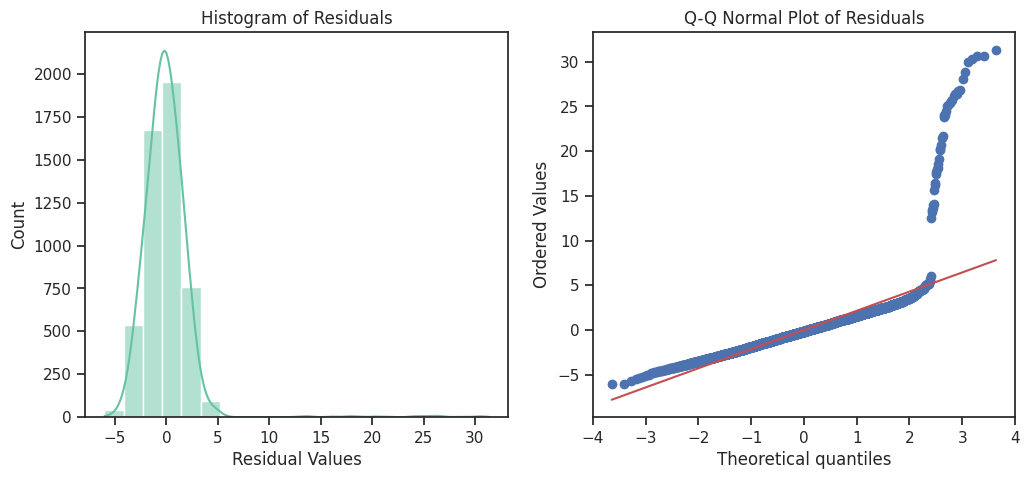

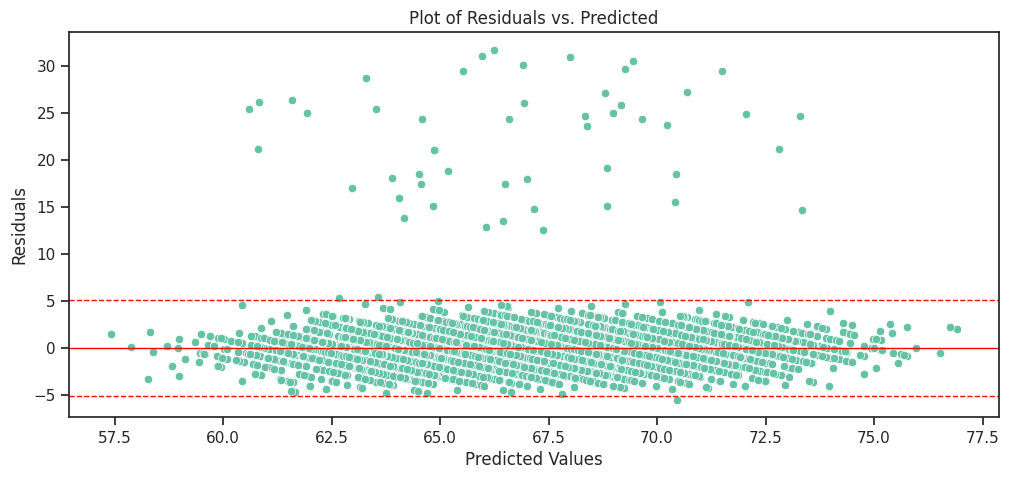

  Metric     Train      Test
0   RMSE  2.664209  2.649839
1    MAE  1.536579  1.531107


In [ ]:
formula = 'Exam_Score ~ Hours_Studied + Attendance + I(Hours_Studied*Attendance)'
results = ols_train_test_split_and_evaluate(df, formula)

# Error metrics as a dictionary
error_metrics = results['error_metrics']
# Convert the dictionary into a pandas DataFrame
metrics_df = pd.DataFrame(
    {
        'Metric': ['RMSE', 'MAE'],
        'Train': [error_metrics['train_rmse'], error_metrics['train_mae']],
        'Test': [error_metrics['test_rmse'], error_metrics['test_mae']]
    }
)

# Display the table
print(metrics_df)
models_metrics['Model 3'] = error_metrics

#### Academic Effort and Family Background

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     1694.
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        21:44:51   Log-Likelihood:                -12034.
No. Observations:                5102   AIC:                         2.408e+04
Df Residuals:                    5097   BIC:                         2.411e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

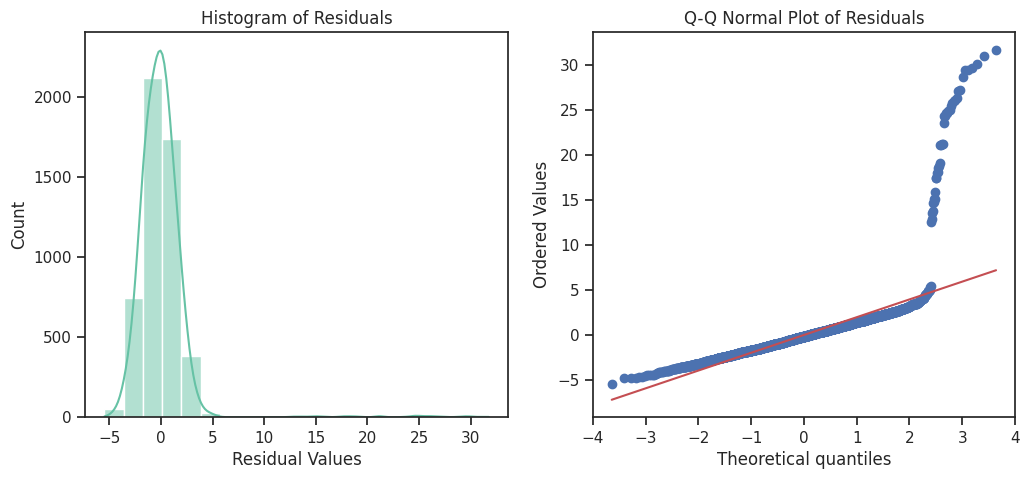

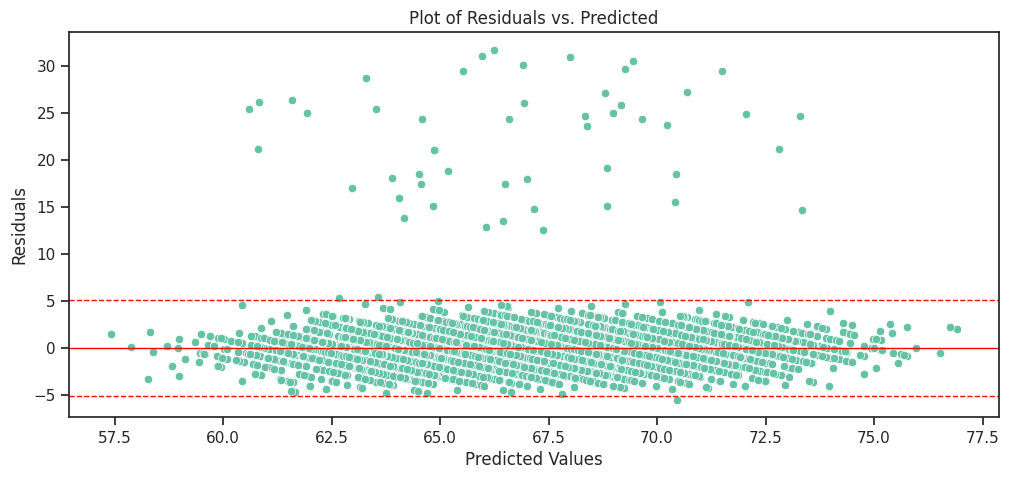

  Metric     Train      Test
0   RMSE  2.559575  2.527683
1    MAE  1.407458  1.387336


In [ ]:
formula = 'Exam_Score ~ Hours_Studied + Attendance + Parental_Involvement + Parental_Education_Level'
results = ols_train_test_split_and_evaluate(df, formula)

# Error metrics as a dictionary
error_metrics = results['error_metrics']
# Convert the dictionary into a pandas DataFrame
metrics_df = pd.DataFrame(
    {
        'Metric': ['RMSE', 'MAE'],
        'Train': [error_metrics['train_rmse'], error_metrics['train_mae']],
        'Test': [error_metrics['test_rmse'], error_metrics['test_mae']]
    }
)

# Display the table
print(metrics_df)

models_metrics['Model 4'] = error_metrics

In [ ]:
# Convert into a DataFrame for error metrics
comparison_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    'Train RMSE': [
        models_metrics['Model 1']['train_rmse'],
        models_metrics['Model 2']['train_rmse'],
        models_metrics['Model 3']['train_rmse'],
        models_metrics['Model 4']['train_rmse']
    ],
    'Test RMSE': [
        models_metrics['Model 1']['test_rmse'],
        models_metrics['Model 2']['test_rmse'],
        models_metrics['Model 3']['test_rmse'],
        models_metrics['Model 4']['test_rmse']
    ],
    'Train MAE': [
        models_metrics['Model 1']['train_mae'],
        models_metrics['Model 2']['train_mae'],
        models_metrics['Model 3']['train_mae'],
        models_metrics['Model 4']['train_mae']
    ],
    'Test MAE': [
        models_metrics['Model 1']['test_mae'],
        models_metrics['Model 2']['test_mae'],
        models_metrics['Model 3']['test_mae'],
        models_metrics['Model 4']['test_mae']
    ]
})

### OLS Regression Models: Results and Findings

After analyzing the error metrics and diagnostic plots, Model 1 emerges as the best-performing model among the four OLS models. The comprehensive model explains a substantial portion of the variability in exam scores, with an  R^2  of 62.6%, and all predictors contribute significantly to explaining exam performance. The diagnostic plots reveal potential issues, including non-normality of residuals and heteroscedasticity. However, the relatively low RMSE (2.39 on train, 2.33 on test) and MAE (1.15 on train, 1.13 on test) suggest strong predictive performance with minor average errors. The slightly larger RMSE compared to MAE indicates that the model is not heavily affected by extreme outliers.

Model 2 performs slightly worse than Model 1, with an  R^2  of 58.8%, RMSE (2.51 on train, 2.46 on test), and MAE (1.33 on train, 1.33 on test). The exclusion of family-related predictors (Parental_Involvement, Parental_Education_Level) likely contributed to the decline in explanatory power. Despite this, all remaining predictors remain statistically significant ( p < 0.05 ). Diagnostic plots reveal similar issues of non-normality and heteroscedasticity, highlighting areas for potential refinement.

Model 3 performs worse than both Model 1 and Model 2, with the lowest  R^2  (53.5%), higher RMSE (2.66 on train, 2.65 on test) and MAE (1.54 on train, 1.53 on test). The inclusion of the interaction term between Hours_Studied and Attendance contributes to weaker overall performance and introduces the potential for severe multicollinearity. However, the train-test RMSE and MAE remain close, indicating no significant overfitting. As with the other models, diagnostic plots reveal persistent issues with non-normality and heteroscedasticity.

Model 4 performs better than Model 3 but slightly worse than Model 1 and Model 2. With an  R^2  of 57.1%, RMSE (2.56 on train, 2.53 on test), and MAE (1.41 on train, 1.39 on test), it strikes a balance by including both academic effort and family background predictors. All predictors are statistically significant, confirming their relevance in explaining exam performance. Despite this, issues with non-normality and heteroscedasticity remain.

In [ ]:
# Display error metrics for all models
print(comparison_df)

     Model  Train RMSE  Test RMSE  Train MAE  Test MAE
0  Model 1    2.388662   2.329659   1.151085  1.128729
1  Model 2    2.507568   2.463212   1.327386  1.329928
2  Model 3    2.664209   2.649839   1.536579  1.531107
3  Model 4    2.559575   2.527683   1.407458  1.387336


### Logistic Regression Model

Logistic regression models are employed to analyze and predict the probability of a binary outcome, such as whether a student passes or fails an exam. In this context, the model evaluates how predictors like Hours_Studied, Attendance, and Tutoring_Sessions influence the likelihood of a student achieving a passing score based on a predefined threshold. Logistic regression is the appropriate choice for modeling this binary outcome, as it overcomes the limitations of OLS regression, which would violate assumptions of linearity and homoscedasticity in this scenario.

By estimating the probabilities of passing, the model provides insights into the relative importance of each predictor. These insights can guide targeted interventions, such as increasing tutoring sessions or improving attendance, to enhance student outcomes. Additionally, logistic regression’s interpretability through odds ratios and predicted probabilities makes it a valuable tool for identifying key drivers of success and developing actionable strategies for academic improvement.

In [ ]:
def prepare_data(df, score_threshold=70):
    """
    Prepares the data by adding a binary 'Pass_Fail' column.

    Parameters:
        df (pd.DataFrame): The input dataset.
        score_threshold (int): Threshold for passing the exam.

    Returns:
        pd.DataFrame: Modified DataFrame with 'Pass_Fail' column.
    """
    df['Pass_Fail'] = np.where(df['Exam_Score'] >= score_threshold, 1, 0)
    return df


In [ ]:
def fit_logistic_regression(df, formula):
    """
    Fits a logistic regression model using GLM with a binomial family.

    Parameters:
        df (pd.DataFrame): The input dataset.
        formula (str): The formula for the logistic regression model.

    Returns:
        model: Fitted GLM model.
    """
    model = smf.glm(formula=formula, family=sm.families.Binomial(), data=df).fit()
    print(model.summary())
    return model


In [ ]:
def predict_and_evaluate(df, model):
    """
    Predicts probabilities, converts to binary outcomes, and evaluates the model.

    Parameters:
        df (pd.DataFrame): The input dataset.
        model: Fitted GLM model.

    Returns:
        None
    """
    # Predict probabilities
    df['Pass_Prob'] = model.predict()
    df['Pass_Pred'] = (df['Pass_Prob'] >= 0.5).astype(int)

    # Evaluate model
    print(classification_report(df['Pass_Fail'], df['Pass_Pred']))
    print("Accuracy:", accuracy_score(df['Pass_Fail'], df['Pass_Pred']))

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].hist(df['Pass_Prob'], bins=20)
    ax[0].set_xlim(-0.01, 1.0)
    ax[0].set_title('Histogram of Predicted Probabilities')
    sns.violinplot(x='Pass_Fail', y='Pass_Prob', data=df, ax=ax[1])
    ax[1].set_title('Violin Plot of Probabilities by Pass/Fail')
    plt.show()

    plt.scatter(df['Hours_Studied'], df['Pass_Prob'], alpha=0.5)
    plt.xlabel('Hours Studied')
    plt.ylabel('Pass Probability')
    plt.title('Predicted Probability vs. Hours Studied')
    plt.show()

In [ ]:
def cross_validate_logistic_regression(df, features, target, n_splits=5):
    """
    Performs k-fold cross-validation for logistic regression.

    Parameters:
        df (pd.DataFrame): The input dataset.
        features (list): List of feature column names.
        target (str): Target column name.
        n_splits (int): Number of folds for cross-validation.

    Returns:
        None
    """
    X = df[features]
    y = df[target]
    X = sm.add_constant(X)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
        result = model.fit()

        y_pred_prob = result.predict(X_test)
        y_pred = (y_pred_prob >= 0.5).astype(int)
        accuracy = np.mean(y_pred == y_test)
        cv_scores.append(accuracy)

    print("Cross-validation scores:", cv_scores)
    print("Mean accuracy:", np.mean(cv_scores))

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Pass_Fail   No. Observations:                 6378
Model:                            GLM   Df Residuals:                     6374
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1846.2
Date:                Fri, 20 Dec 2024   Deviance:                       3692.5
Time:                        18:39:12   Pearson chi2:                 7.24e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4179
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -25.1117      0.68

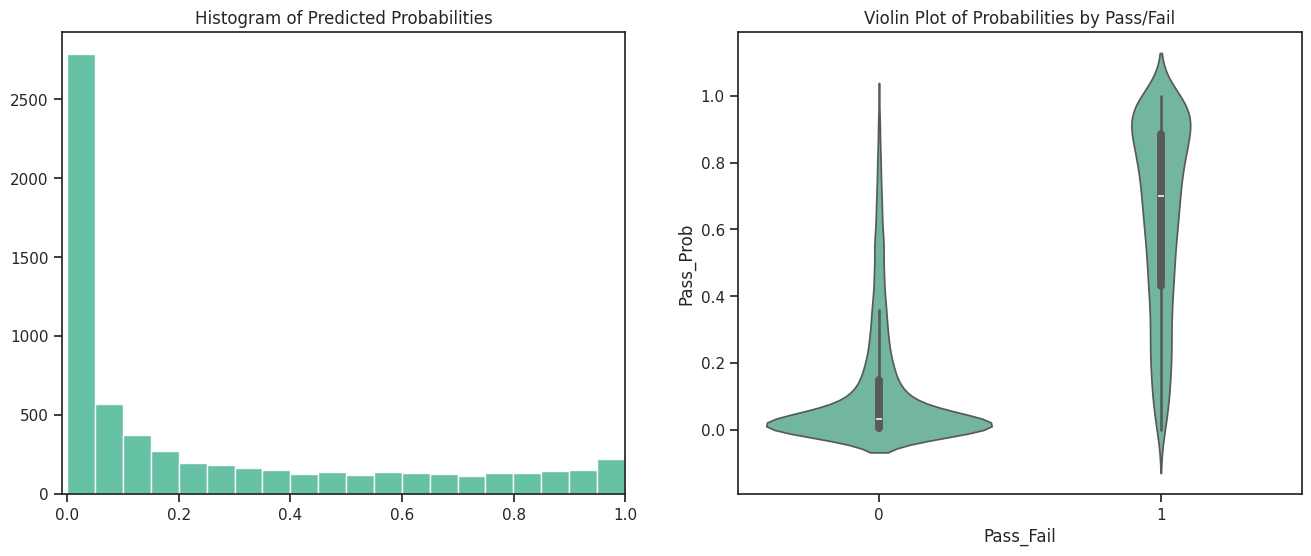

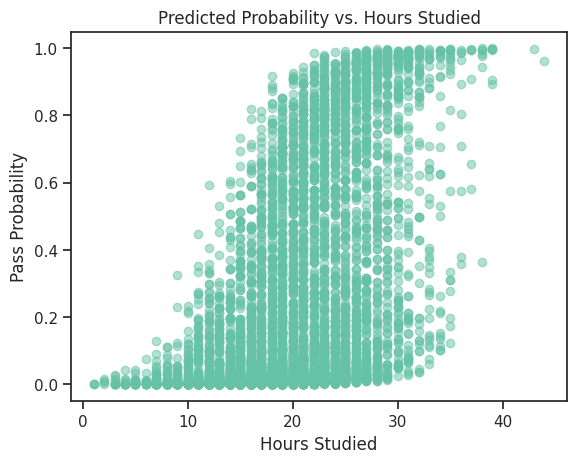

Cross-validation scores: [0.872257053291536, 0.872257053291536, 0.8738244514106583, 0.8886274509803922, 0.8627450980392157]
Mean accuracy: 0.8739422214026676


In [ ]:
df = prepare_data(df)
formula = "Pass_Fail ~ Hours_Studied + Attendance + Tutoring_Sessions"
logistic_model = fit_logistic_regression(df, formula)
predict_and_evaluate(df, logistic_model)
cross_validate_logistic_regression(df, ['Hours_Studied', 'Attendance', 'Tutoring_Sessions'], 'Pass_Fail')

### Logistic Regression Model: Results and Findings

The Logistic Regression model demonstrates strong performance and generalization, achieving a high accuracy of 87.4%, robust classification metrics, and consistent cross-validation scores. All predictors (Hours_Studied, Attendance, and Tutoring_Sessions) significantly influence pass/fail outcomes, with Tutoring_Sessions showing the most substantial impact.

Visual diagnostics further validate the model’s performance. The histogram of predicted probabilities reveals a clear concentration near 0 and 1, indicating that the model makes confident predictions for most observations. The violin plot highlights distinct separations in predicted probabilities for Pass and Fail outcomes, reinforcing the model’s ability to distinguish between the two classes. Additionally, the scatterplot illustrates a positive relationship between hours studied and the likelihood of passing, confirming the intuitive expectation that more study hours lead to higher probabilities of success.

These findings underscore the reliability and accuracy of the Logistic Regression model, providing confidence in its predictions and demonstrating its practical utility in identifying key factors that contribute to student success.

### Poisson Regression Model

Poisson regression is a statistical method used to model and analyze count data—variables that represent the number of occurrences of an event within a fixed period or context. In this case, the model examines the relationship between predictors such as Hours_Studied and Tutoring_Sessions and the count of class attendance. Since attendance is a count variable, Poisson regression is a more appropriate choice than linear regression, as it accommodates the discrete, non-negative nature of count data.

This model aims to identify key factors influencing attendance rates, providing actionable insights into improving class participation. By quantifying the impact of predictors, such as study habits or external support through tutoring, the model helps to develop targeted strategies for boosting attendance. Poisson regression is a powerful tool for understanding count-based outcomes, offering data-driven solutions to optimize event occurrences, such as enhancing attendance rates through effective interventions.

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Attendance   No. Observations:                 6378
Model:                            GLM   Df Residuals:                     6375
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -25157.
Date:                Fri, 20 Dec 2024   Deviance:                       10696.
Time:                        18:54:22   Pearson chi2:                 1.06e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0002824
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3825      0.00

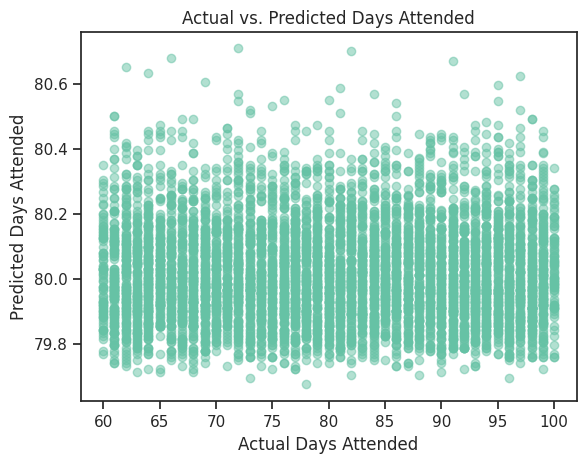

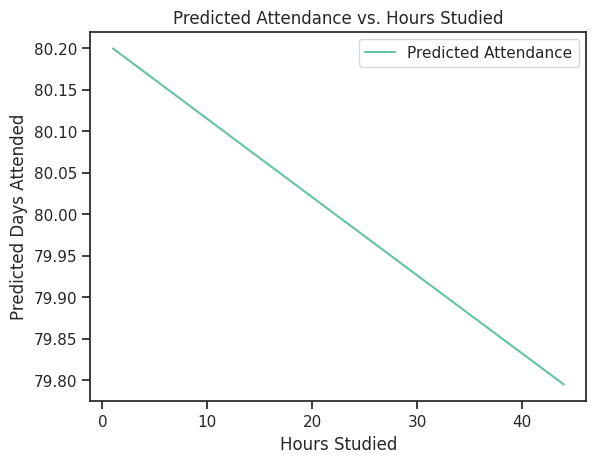

Mean of Attendance: 80.02085293195358
Variance of Attendance: 133.41919814333343


In [ ]:
def poisson_regression_analysis(df, formula, simulate_hours_range=None):
    """
    Fits a Poisson regression model, evaluates it, and provides visualizations.

    Parameters:
        df (pd.DataFrame): The input dataset.
        formula (str): The formula for the Poisson regression model.
        simulate_hours_range (tuple): Range (min, max) for simulating 'Hours_Studied' values.
                                      Default is None, which uses the min/max from the dataset.

    Returns:
        model: The fitted Poisson regression model.
    """
    # Check for non-negative attendance values
    assert (df['Attendance'] >= 0).all(), "Attendance must be non-negative."

    # Fit the Poisson regression model
    poisson_model = smf.glm(formula=formula, family=sm.families.Poisson(), data=df).fit()
    print(poisson_model.summary())

    # Exponentiated coefficients (rate ratios)
    print("Exponentiated Coefficients (Rate Ratios):")
    print(np.exp(poisson_model.params))

    # Predict for the dataset
    df['Predicted_Attendance'] = poisson_model.predict()

    # Visualize Actual vs Predicted Attendance
    plt.scatter(df['Attendance'], df['Predicted_Attendance'], alpha=0.5)
    plt.xlabel('Actual Days Attended')
    plt.ylabel('Predicted Days Attended')
    plt.title('Actual vs. Predicted Days Attended')
    plt.show()

    # Simulate Hours_Studied values if a range is provided
    if simulate_hours_range is None:
        simulate_hours_range = (df['Hours_Studied'].min(), df['Hours_Studied'].max())

    simulated_hours = np.linspace(simulate_hours_range[0], simulate_hours_range[1], 100)
    simulated_data = pd.DataFrame({
        'Hours_Studied': simulated_hours,
        'Tutoring_Sessions': np.mean(df['Tutoring_Sessions'])  # Use mean tutoring sessions for simulation
    })
    simulated_data['Predicted_Attendance'] = poisson_model.predict(simulated_data)

    # Plot Predicted Attendance vs. Hours Studied
    plt.plot(simulated_hours, simulated_data['Predicted_Attendance'], label="Predicted Attendance")
    plt.xlabel('Hours Studied')
    plt.ylabel('Predicted Days Attended')
    plt.title('Predicted Attendance vs. Hours Studied')
    plt.legend()
    plt.show()

    # Print mean and variance of the Attendance
    print("Mean of Attendance:", df['Attendance'].mean())
    print("Variance of Attendance:", df['Attendance'].var())

    return poisson_model

# Example Usage
formula = "Attendance ~ Hours_Studied + Tutoring_Sessions"
poisson_model = poisson_regression_analysis(df, formula)

### Poisson Regression Model: Results and Findings

The Poisson regression model demonstrates poor performance, as evidenced by the extremely low  R^2  value of 0.0002824 and the lack of significant effects from both Hours_Studied and Tutoring_Sessions on attendance. The scatterplot reveals that predicted attendance values cluster tightly around a single range (approximately 80 days), regardless of actual attendance values. This indicates the model fails to capture meaningful variability in attendance.

Furthermore, the linear relationship between predicted attendance and Hours_Studied is nearly flat, underscoring the negligible impact of study hours on expected attendance. The appropriateness of the Poisson model is further called into question by the mismatch between the mean (80.02) and variance (133.42) of the dependent variable, as the Poisson assumption requires these values to be approximately equal. The larger variance suggests overdispersion, making the Poisson regression model an inadequate choice for this data.

### Bayesian Regression Model

This Bayesian regression model analyzes and predicts Exam_Score using three predictors: Hours_Studied, Attendance, and Previous_Scores. By incorporating prior beliefs about the model parameters, it leverages probabilistic inference to estimate their posterior distributions. This approach offers flexibility in integrating prior knowledge, such as the assumed importance of Previous_Scores, while explicitly modeling uncertainty.

Bayesian regression excels in scenarios with limited or noisy data, as it “borrows strength” from priors to produce more stable estimates. The ability to quantify uncertainty in the parameter estimates and predictions makes it particularly valuable for robust decision-making. This probabilistic framework provides a nuanced understanding of the relationship between predictors and Exam_Score, enabling reliable predictions and insights.

In [ ]:
# Prepare the data
X = df[['Hours_Studied', 'Attendance', 'Previous_Scores']]
y = df['Exam_Score']

# Normalize data for better convergence
X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Bayesian Regression Model
with pm.Model() as model:
    # Priors for coefficients
    intercept = pm.Normal('Intercept', mu=0, sigma=10)
    beta_hours = pm.Normal('Beta_Hours_Studied', mu=0, sigma=10)
    beta_attendance = pm.Normal('Beta_Attendance', mu=0, sigma=10)
    beta_previous_scores = pm.Normal('Beta_Previous_Scores', mu=1, sigma=5)  # Prior info

    # Likelihood
    mu = (intercept +
          beta_hours * X['Hours_Studied'] +
          beta_attendance * X['Attendance'] +
          beta_previous_scores * X['Previous_Scores'])
    sigma = pm.HalfNormal('Sigma', sigma=1)

    likelihood = pm.Normal('Exam_Scores', mu=mu, sigma=sigma, observed=y)

    # Inference
    trace = pm.sample(1000, tune=500, return_inferencedata=True)

# Summary of results
pm.summary(trace)

Output()

Output()

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Beta_Attendance       0.586  0.008   0.571    0.602        0.0      0.0   
Beta_Hours_Studied    0.444  0.008   0.429    0.460        0.0      0.0   
Beta_Previous_Scores  0.175  0.008   0.160    0.190        0.0      0.0   
Intercept             0.000  0.008  -0.014    0.017        0.0      0.0   
Sigma                 0.658  0.006   0.647    0.669        0.0      0.0   

                      ess_bulk  ess_tail  r_hat  
Beta_Attendance         2674.0    1662.0    1.0  
Beta_Hours_Studied      2780.0    1573.0    1.0  
Beta_Previous_Scores    2464.0    1487.0    1.0  
Intercept               1593.0    1511.0    1.0  
Sigma                   2230.0    1469.0    1.0

array([[<Axes: title={'center': 'Beta_Attendance'}>,
        <Axes: title={'center': 'Beta_Hours_Studied'}>,
        <Axes: title={'center': 'Beta_Previous_Scores'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Sigma'}>, <Axes: >]], dtype=object)

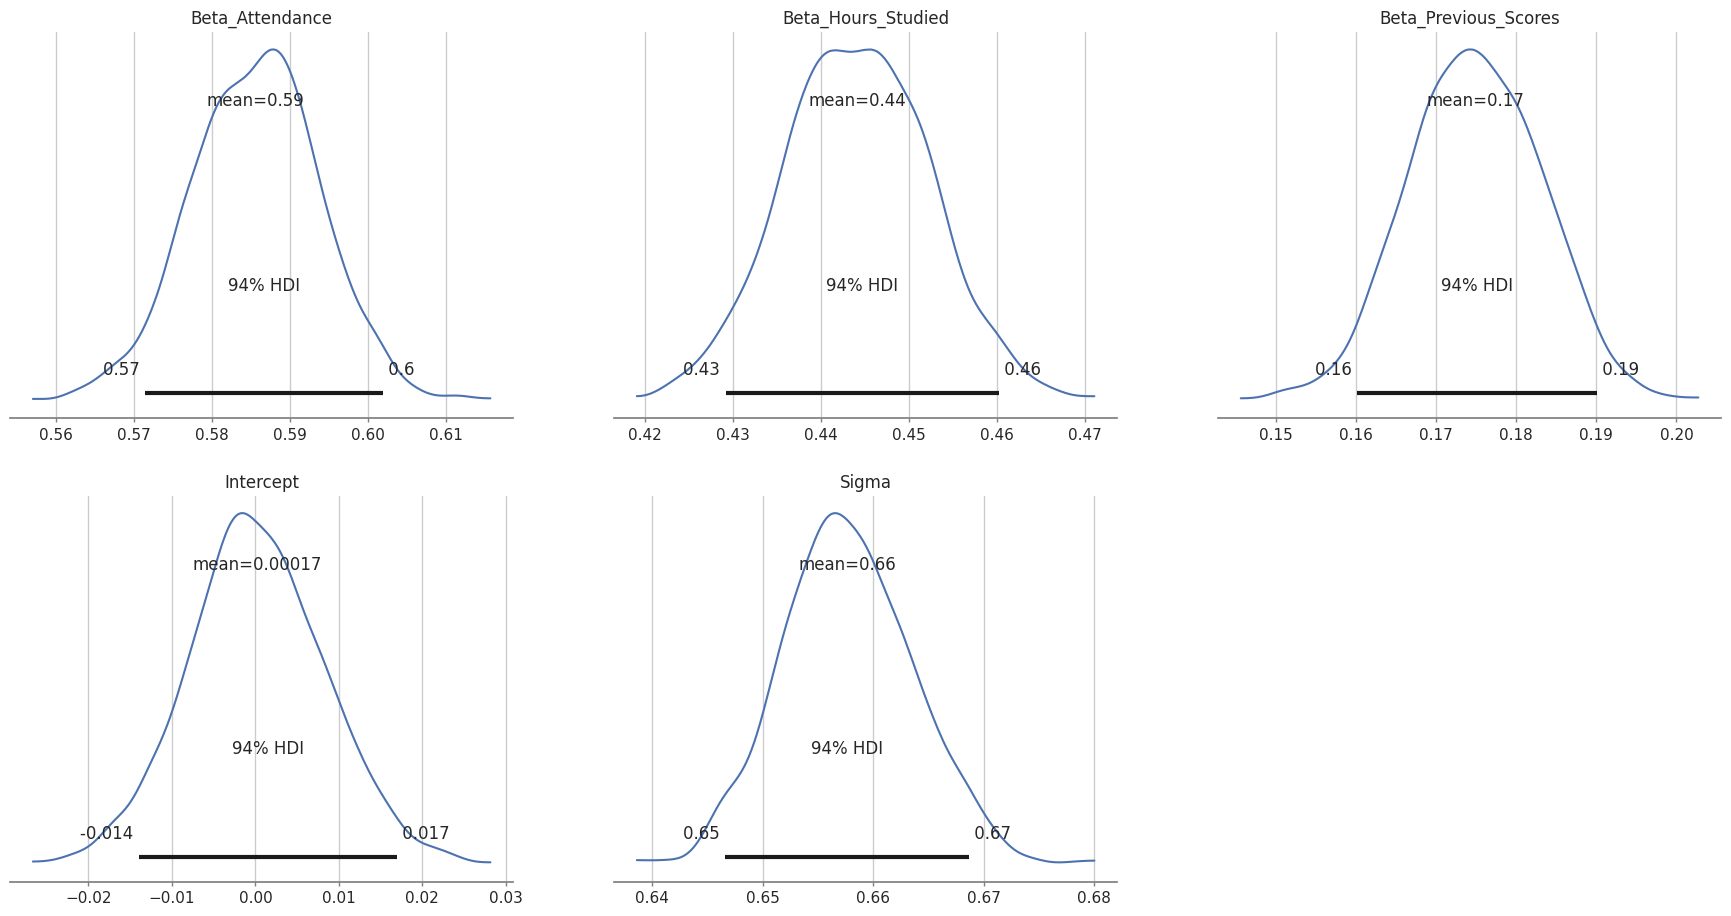

In [ ]:
az.plot_posterior(trace)

### Bayesian Regression Model: Results and Findings

The Bayesian model offers clear probabilistic insights into the effects of the predictors while effectively accounting for uncertainty. Among the predictors, Attendance emerges as the strongest contributor to Exam_Score, followed by Hours_Studied and Previous_Scores. All predictors contribute positively and significantly to the outcome variable, highlighting their importance in explaining exam performance.

The model demonstrates strong convergence, as indicated by high Effective Sample Size (ESS) values and  R_{\hat{}} = 1.0  for all parameters. This ensures reliable posterior estimates and reinforces the stability of the model. Additionally, the narrow credible intervals and small standard deviations for the parameters reflect low uncertainty in the estimates, providing confidence in their accuracy and interpretability.

The Bayesian framework not only quantifies the likely effect of each predictor but also explicitly accounts for variability, making it a valuable tool for robust prediction. The results underscore the significance of both academic effort and prior performance in shaping exam outcomes, while the model’s probabilistic approach ensures flexibility and reliability even in scenarios with data limitations or noise.

### Hierarchical Bayesian Model

Hierarchical Bayesian models, also known as multilevel models, are designed to analyze data with a nested or grouped structure. In this context, the model evaluates Exam_Score while accounting for variability across groups defined by Parental_Education_Level. By incorporating both group-level and population-level effects, it provides a robust and flexible framework for understanding how predictors influence outcomes both within and across groups.

The key advantage of this approach is its ability to tailor insights to specific parental education groups, identifying unique characteristics that can inform targeted educational interventions. Additionally, it allows for the analysis of how predictors, such as Attendance, operate differently across groups. By combining group-specific and population-level effects, the model delivers insights that can guide both localized and broad policy decisions, offering a comprehensive view of the relationships between predictors and exam performance.

In [ ]:
with pm.Model() as hierarchical_model:
    # Define group-level intercepts and slopes
    group_idx = pd.Categorical(df['Parental_Education_Level']).codes  # Encode groups
    n_groups = len(df['Parental_Education_Level'].unique())

    # Group-level priors
    group_intercept = pm.Normal('Group_Intercept', mu=0, sigma=5, shape=n_groups)
    group_slope_hours = pm.Normal('Group_Slope_Hours', mu=0, sigma=5, shape=n_groups)
    group_slope_attendance = pm.Normal('Group_Slope_Attendance', mu=0, sigma=5, shape=n_groups)

    # Population-level priors
    population_intercept = pm.Normal('Population_Intercept', mu=0, sigma=10)
    population_slope_hours = pm.Normal('Population_Slope_Hours', mu=0, sigma=10)
    population_slope_attendance = pm.Normal('Population_Slope_Attendance', mu=0, sigma=10)
    population_slope_parental_involvement = pm.Normal('Population_Slope_Parental', mu=0, sigma=10)

    # Linear model
    mu = (population_intercept +
          group_intercept[group_idx] +
          (population_slope_hours + group_slope_hours[group_idx]) * df['Hours_Studied'] +
          (population_slope_attendance + group_slope_attendance[group_idx]) * df['Attendance'] +
          population_slope_parental_involvement * df['Parental_Involvement'])

    # Likelihood
    sigma = pm.HalfNormal('Sigma', sigma=1)
    likelihood = pm.Normal('Exam_Score', mu=mu, sigma=sigma, observed=df['Exam_Score'])

    # Inference
    hierarchical_trace = pm.sample(1000, tune=500, return_inferencedata=True)

# Summary of results
pm.summary(hierarchical_trace)

Output()

Output()

ERROR:pymc.stats.convergence:There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Group_Intercept[0]            7.606  5.057  -0.329   12.398      3.326   
Group_Intercept[1]            7.799  5.113  -0.256   12.604      3.366   
Group_Intercept[2]            9.060  4.787   1.278   13.487      3.121   
Group_Slope_Attendance[0]    -0.269  0.957  -1.110    1.562      0.655   
Group_Slope_Attendance[1]    -0.267  0.960  -1.108    1.565      0.657   
Group_Slope_Attendance[2]    -0.275  0.956  -1.114    1.552      0.654   
Group_Slope_Hours[0]         -0.019  2.229  -4.875    4.582      0.469   
Group_Slope_Hours[1]         -0.016  2.228  -4.813    4.619      0.468   
Group_Slope_Hours[2]         -0.021  2.227  -4.854    4.584      0.468   
Population_Intercept         36.768  4.836  32.251   44.422      3.159   
Population_Slope_Attendance   0.465  0.956  -1.364    1.305      0.655   
Population_Slope_Hours        0.311  2.227  -4.289    5.161      0.468   
Population_Slope_Parental     0.948  0.032   0.878    1.011      0.002   
Sigma                         2.566  0.020   2.522    2.592      0.007   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
Group_Intercept[0]             2.945       3.0      11.0   1.93  
Group_Intercept[1]             2.978       3.0      37.0   2.20  
Group_Intercept[2]             2.744       3.0      51.0   1.92  
Group_Slope_Attendance[0]      0.547       2.0      12.0   2.86  
Group_Slope_Attendance[1]      0.549       2.0      12.0   2.89  
Group_Slope_Attendance[2]      0.547       2.0      12.0   2.79  
Group_Slope_Hours[0]           0.549      24.0      29.0   1.85  
Group_Slope_Hours[1]           0.549      25.0      29.0   1.91  
Group_Slope_Hours[2]           0.549      24.0      29.0   1.87  
Population_Intercept           2.592       3.0      30.0   2.10  
Population_Slope_Attendance    0.547       2.0      12.0   2.87  
Population_Slope_Hours         0.537      24.0      29.0   1.89  
Population_Slope_Parental      0.001     206.0     143.0   1.79  
Sigma                          0.005       9.0     151.0   1.85

array([[<Axes: title={'center': 'Group_Slope_Hours\n0'}>,
        <Axes: title={'center': 'Group_Slope_Hours\n1'}>,
        <Axes: title={'center': 'Group_Slope_Hours\n2'}>],
       [<Axes: title={'center': 'Group_Slope_Attendance\n0'}>,
        <Axes: title={'center': 'Group_Slope_Attendance\n1'}>,
        <Axes: title={'center': 'Group_Slope_Attendance\n2'}>]],
      dtype=object)

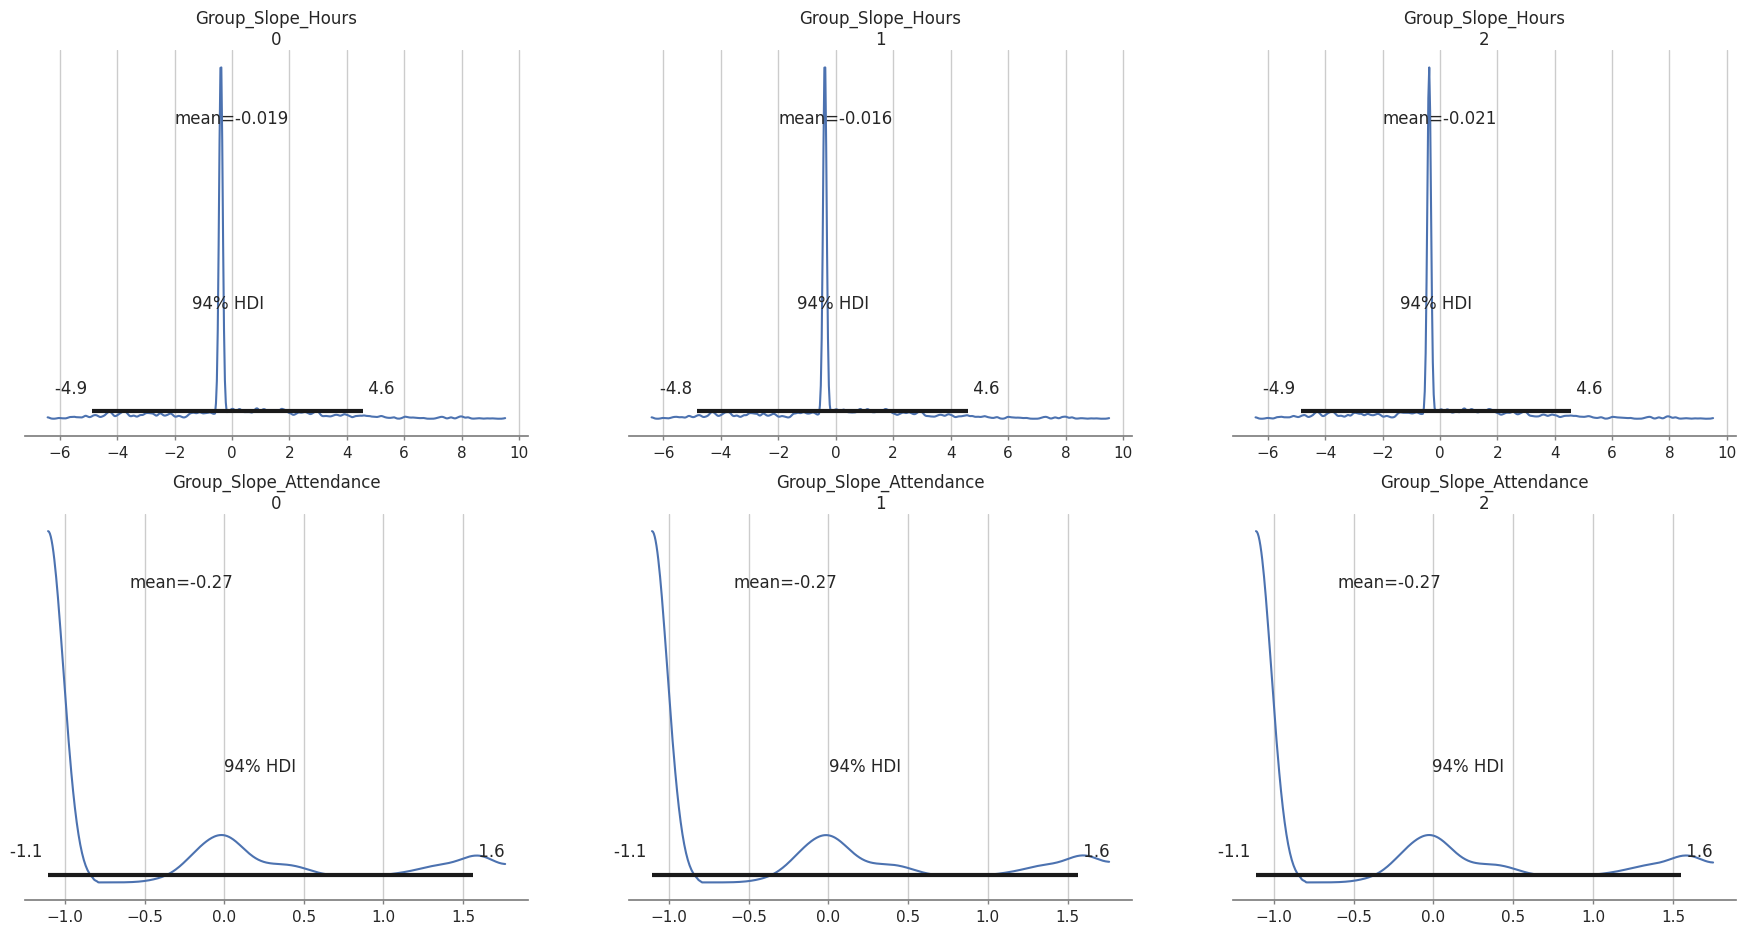

In [ ]:
az.plot_posterior(hierarchical_trace, var_names=['Group_Slope_Hours', 'Group_Slope_Attendance'])

### Hierarchical Bayesian Model: Results and Findings

The results of the Hierarchical Bayesian model reveal that population-level effects play a dominant role in explaining Exam_Score. Among the predictors, Parental_Involvement emerges as the most significant factor, followed by Attendance and Hours_Studied, all of which contribute positively and meaningfully to the outcome variable. These findings highlight the importance of both family-related and individual academic factors in shaping exam performance.

At the group-level, the effects for slopes are minimal, indicating that the predictors do not vary substantially in their influence on the outcome across groups defined by Parental_Education_Level. This suggests that while group-level variability exists, its impact on the relationships between predictors and the outcome is limited.

However, the model’s diagnostics raise concerns about group-level estimates. High  R_hat  values and low Effective Sample Sizes (ESS) for group-level parameters point to convergence issues, which weakens confidence in these estimates. These issues highlight the need for further refinement, such as increasing the number of samples or tuning hyperparameters, to achieve better convergence and reliability at the group level.

In contrast, the population-level predictors provide stable and reliable insights, with well-converged parameters and narrow credible intervals, underscoring their importance in explaining the overall variance in Exam_Score. The small and uncertain group-level variations suggest that population-level effects should be prioritized when interpreting the model results and making data-driven decisions.

### Conclusion

The analysis revealed critical insights into the factors influencing student exam performance by leveraging multiple modeling approaches, including OLS regression, Logistic Regression, Bayesian methods, Hierarchical Bayesian modeling, and Poisson regression. Each method offered unique perspectives, comprehensively understanding the relationships between predictors and outcomes. The comprehensive model (Model 1) performed best among the OLS models, explaining 62.6% of the variability in Exam_Score. It highlighted the significant contributions of family-related predictors such as Parental_Involvement and Parental_Education_Level, emphasizing the importance of external support alongside academic effort. However, diagnostic issues like heteroscedasticity and non-normality of residuals suggest further refinement of these models.

The Logistic Regression model excelled at predicting binary outcomes, achieving an accuracy of 87.4%. Predictors such as Tutoring_Sessions, Hours_Studied, and Attendance significantly influenced pass/fail outcomes, with tutoring having the most substantial impact. The model’s consistent cross-validation performance and clear visual separation between predicted probabilities for pass and fail outcomes instill confidence in its reliability. Bayesian regression further complemented these insights by providing probabilistic estimates, with Attendance emerging as the strongest predictor. Its narrow, credible intervals and strong convergence metrics underscore the robustness of the estimates, making it a valuable tool for noisy or limited data scenarios.

The Hierarchical Bayesian model offered a nuanced view of group-level and population-level effects, revealing that Parental_Involvement is the most significant predictor across groups. However, group-level variations were minimal, and convergence issues for some parameters weakened confidence in group-specific estimates. Finally, the Poisson regression model struggled to explain variability in Attendance due to overdispersion in the data, indicating that a Negative Binomial model would be more appropriate for count-based outcomes like Attendance.

Refining the models is essential to address diagnostic issues, particularly for OLS and Poisson regression. Incorporating additional predictors, exploring interaction terms, and considering longitudinal approaches could further enhance the analysis. The Logistic Regression and Bayesian models can be reliable tools for predicting student outcomes and identifying at-risk students, guiding targeted interventions such as increased tutoring or attendance monitoring. Moreover, insights from the Hierarchical Bayesian model can inform broad and localized educational policies, focusing on enhancing parental involvement and improving study habits. These findings provide a robust foundation for actionable strategies and future research to optimize student success.